# Advanced Machine Learning - Project 1
As cardiovascular diseases are cause of a big part of deaths worldwide, it is important to be able to **predict** them. In this project, we will try to predict the presence or absence of cardiovascular disease using the patient examination results and techniques related with **Bayesian Networks**.

## Table of Content
1. Data import and cleaning
2. Descriptive statistics and distributions
3. Dealing with missing values
4. SMOTE-NC + Undersampling
5. Create categorical features from continuous features
6. Structure Leaning
7. Parameter Learning
8. Prediction
9. Conclusion and next steps

Appendix: Testing for quintile categorization


In [1]:
# Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from collections import Counter

# Data Upscaling or Downscaling
from sklearn.model_selection import train_test_split
import imblearn.over_sampling as over_sampling
import imblearn.under_sampling as under_sampling

# Bayesian network and estimators
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator

from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.estimators import ExhaustiveSearch
from pgmpy.estimators import HillClimbSearch

from pgmpy.inference import VariableElimination

from pgmpy.base import DAG

# visualization
import networkx as nx

# test scores
from sklearn.metrics import f1_score, classification_report


/Users/tildietrich/Library/CloudStorage/OneDrive-Personal/ulisboa/1-semester/advanced-ml/Project1-AAA/python-aml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting a random seed to make results reproducible.

In [2]:
# set general params
sns.set_style("whitegrid")

# set some pseudo-random params for reproducability
random_state = 420
random.seed(random_state)

# 1. Data import and cleaning
Importing and observing the original data and format.

In [3]:
# Reading the dataset
df = pd.read_csv("../CHD_dataset.csv")

df.head(10)

,Sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,male,39,4.0,No,0.0,0.0,0,0,No,195.0,106.0,70.0,26.97,80.0,77.0,0
1,female,46,2.0,No,0.0,0.0,0,0,No,250.0,121.0,81.0,28.73,95.0,76.0,0
2,male,48,1.0,Yes,20.0,0.0,0,0,No,245.0,127.5,80.0,25.34,75.0,70.0,0
3,female,61,3.0,Yes,30.0,0.0,0,1,No,225.0,150.0,95.0,28.58,65.0,103.0,1
4,female,46,3.0,Yes,23.0,0.0,0,0,No,285.0,130.0,84.0,23.10,85.0,85.0,0
5,female,43,2.0,No,0.0,0.0,0,1,No,228.0,180.0,110.0,30.30,77.0,99.0,0
6,female,63,1.0,No,0.0,0.0,0,0,No,205.0,138.0,71.0,33.11,60.0,85.0,1
7,female,45,2.0,Yes,20.0,0.0,0,0,No,313.0,100.0,71.0,21.68,79.0,78.0,0
8,male,52,1.0,No,0.0,0.0,0,1,No,260.0,141.5,89.0,26.36,76.0,79.0,0
9,male,43,1.0,Yes,30.0,0.0,0,1,No,225.0,162.0,107.0,23.61,93.0,88.0,0


## Rename variables according to the following convention
This makes it easier to distinguish between the different types of variables. The convention is as follows:
- cat_{varname}: categorical variable,
- ord_{varname}: ordinal variable,
- cont_{varname}: continuous variable

In [4]:
# Rename variables according to this convention
# cat_{varname}: categorical variable
# ord_{varname}: ordinal variable
# cont_{varname}: continuous variable

df.rename(columns={
    'Sex': 'cat_assigned_sex',
    'age': 'cont_age',
    'education': 'ord_education',
    'currentSmoker': 'cat_current_smoker',
    'cigsPerDay': 'cont_cigs_per_day',
    'BPMeds': 'cat_bp_meds',
    'prevalentStroke': 'cat_prev_stroke',
    'prevalentHyp': 'cat_prev_hypertense',
    'diabetes': 'cat_diabetes',
    'totChol': 'cont_total_cholesterol',
    'sysBP': 'cont_systolic_bp',
    'diaBP': 'cont_diastolic_bp',
    'BMI': 'cont_bmi', 
    'heartRate': 'cont_heart_rate',
    'glucose': 'cont_glucose',
    'TenYearCHD': 'cat_ten_year_chd'
}, inplace=True)

df.head(5)

,cat_assigned_sex,cont_age,ord_education,cat_current_smoker,cont_cigs_per_day,cat_bp_meds,cat_prev_stroke,cat_prev_hypertense,cat_diabetes,cont_total_cholesterol,cont_systolic_bp,cont_diastolic_bp,cont_bmi,cont_heart_rate,cont_glucose,cat_ten_year_chd
0,male,39,4.0,No,0.0,0.0,0,0,No,195.0,106.0,70.0,26.97,80.0,77.0,0
1,female,46,2.0,No,0.0,0.0,0,0,No,250.0,121.0,81.0,28.73,95.0,76.0,0
2,male,48,1.0,Yes,20.0,0.0,0,0,No,245.0,127.5,80.0,25.34,75.0,70.0,0
3,female,61,3.0,Yes,30.0,0.0,0,1,No,225.0,150.0,95.0,28.58,65.0,103.0,1
4,female,46,3.0,Yes,23.0,0.0,0,0,No,285.0,130.0,84.0,23.10,85.0,85.0,0


We recode categorical and ordinal variables into strings for interpretable categoriesa there is no need for purely numerical inputs in bayesian networks and it improves readability of CDP outputs.

In [5]:
df['ord_education'] = df['ord_education'].replace({1: 'some high school', 
                                                   2: 'high school/GED',
                                                   3: 'some college/vocational school',
                                                   4: 'college'})

# loop through dummy columns
cols = ['cat_bp_meds', 'cat_prev_stroke', 'cat_prev_hypertense', 'cat_ten_year_chd']

for col in cols:
    df[col] = df[col].replace({0: 'No',
                               1: 'Yes'})

df.head(5)


,cat_assigned_sex,cont_age,ord_education,cat_current_smoker,cont_cigs_per_day,cat_bp_meds,cat_prev_stroke,cat_prev_hypertense,cat_diabetes,cont_total_cholesterol,cont_systolic_bp,cont_diastolic_bp,cont_bmi,cont_heart_rate,cont_glucose,cat_ten_year_chd
0,male,39,college,No,0.0,No,No,No,No,195.0,106.0,70.0,26.97,80.0,77.0,No
1,female,46,high school/GED,No,0.0,No,No,No,No,250.0,121.0,81.0,28.73,95.0,76.0,No
2,male,48,some high school,Yes,20.0,No,No,No,No,245.0,127.5,80.0,25.34,75.0,70.0,No
3,female,61,some college/vocational school,Yes,30.0,No,No,Yes,No,225.0,150.0,95.0,28.58,65.0,103.0,Yes
4,female,46,some college/vocational school,Yes,23.0,No,No,No,No,285.0,130.0,84.0,23.10,85.0,85.0,No


## 2. Descriptive Statistics and distributions
Observing the plots of the variables can help with understanding the distribution of the data along the dataset, which helps to further down the pipeline to categorize the continuous variables.

count    4240.000000
mean       49.580189
std         8.572942
min        32.000000
25%        42.000000
50%        49.000000
75%        56.000000
max        70.000000
Name: cont_age, dtype: float64

NaNs: 0.0




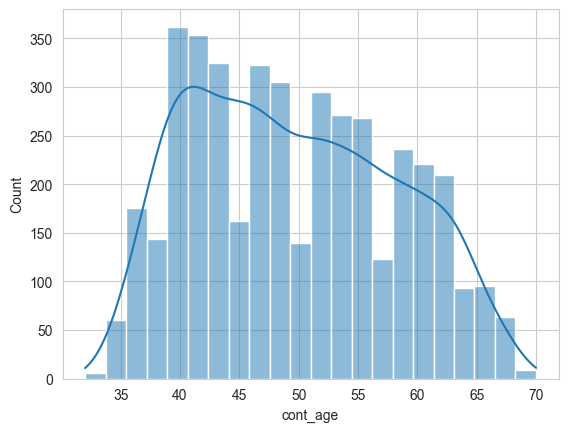

count    4211.000000
mean        9.005937
std        11.922462
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max        70.000000
Name: cont_cigs_per_day, dtype: float64

NaNs: 29.0




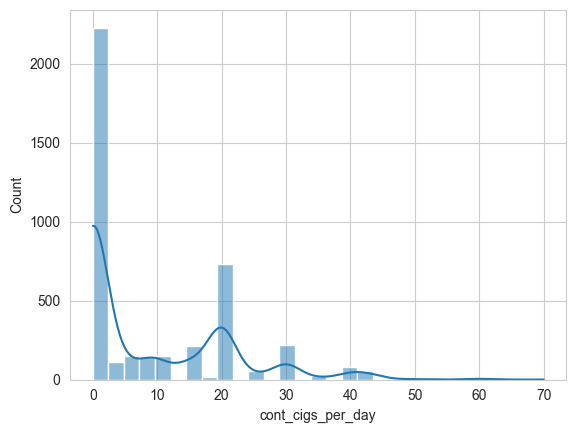

count    4190.000000
mean      236.699523
std        44.591284
min       107.000000
25%       206.000000
50%       234.000000
75%       263.000000
max       696.000000
Name: cont_total_cholesterol, dtype: float64

NaNs: 50.0




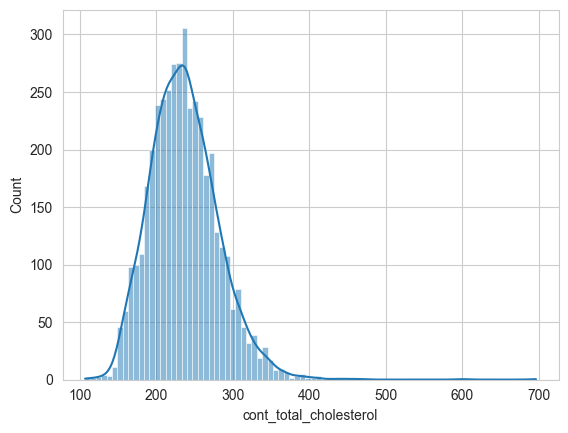

count    4240.000000
mean      132.354599
std        22.033300
min        83.500000
25%       117.000000
50%       128.000000
75%       144.000000
max       295.000000
Name: cont_systolic_bp, dtype: float64

NaNs: 0.0




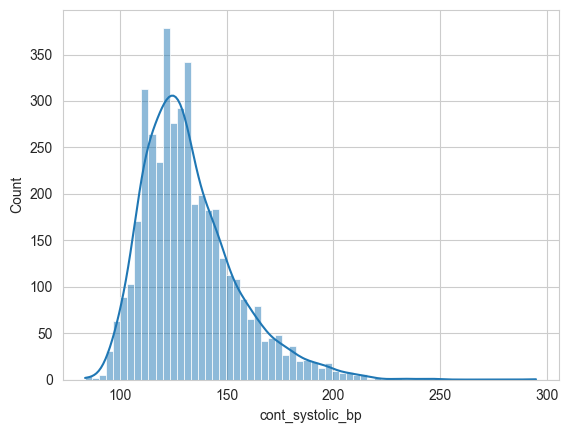

count    4240.000000
mean       82.897759
std        11.910394
min        48.000000
25%        75.000000
50%        82.000000
75%        90.000000
max       142.500000
Name: cont_diastolic_bp, dtype: float64

NaNs: 0.0




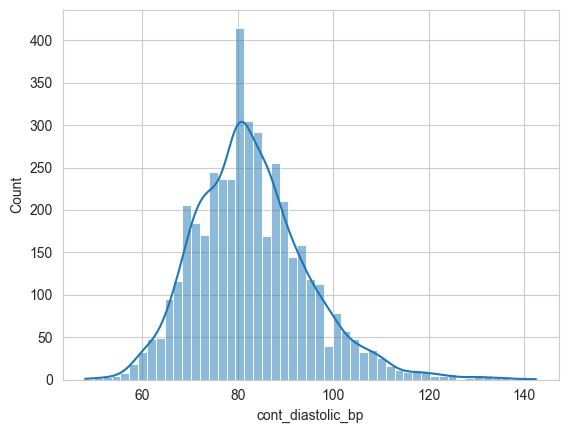

count    4221.000000
mean       25.800801
std         4.079840
min        15.540000
25%        23.070000
50%        25.400000
75%        28.040000
max        56.800000
Name: cont_bmi, dtype: float64

NaNs: 19.0




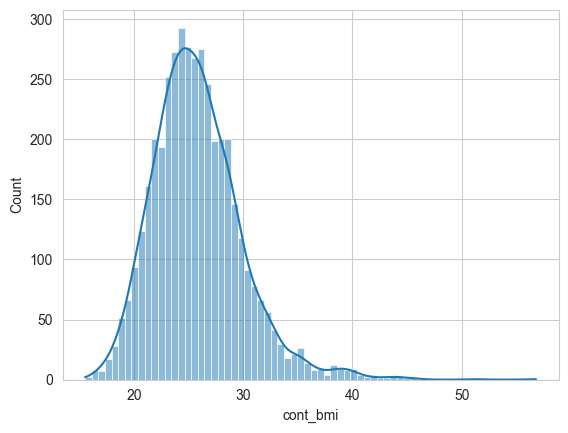

count    4239.000000
mean       75.878981
std        12.025348
min        44.000000
25%        68.000000
50%        75.000000
75%        83.000000
max       143.000000
Name: cont_heart_rate, dtype: float64

NaNs: 1.0




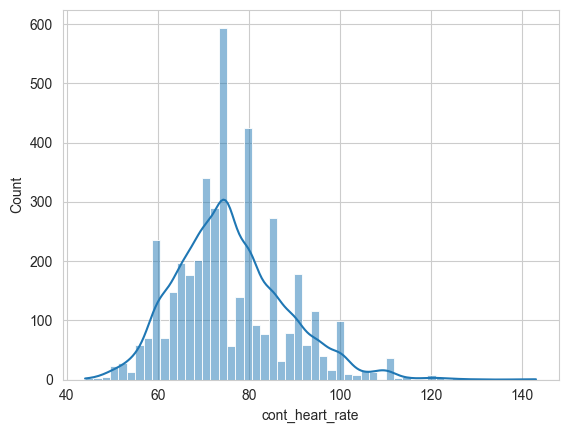

count    3852.000000
mean       81.963655
std        23.954335
min        40.000000
25%        71.000000
50%        78.000000
75%        87.000000
max       394.000000
Name: cont_glucose, dtype: float64

NaNs: 388.0




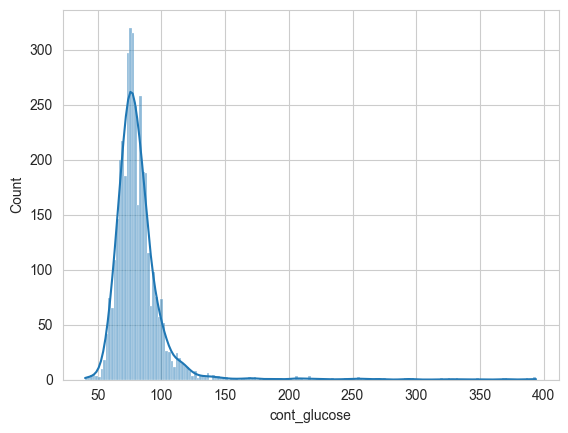

In [6]:
# continuous variables
cont_cols = [col for col in df.columns if col.startswith('cont_')]

for col in cont_cols:
    desc = df[col].describe()
    print(desc)
    print(f'\nNaNs: {len(df) - desc.loc["count"]}')
    print('\n')
    sns.histplot(df[col], bins='auto', kde=True)
    plt.show()

Frequencies for cat_assigned_sex:
cat_assigned_sex
female    2420
male      1820
Name: count, dtype: int64

Percentage Frequencies:
cat_assigned_sex
female    57.075472
male      42.924528
Name: proportion, dtype: float64

NaNs: 0




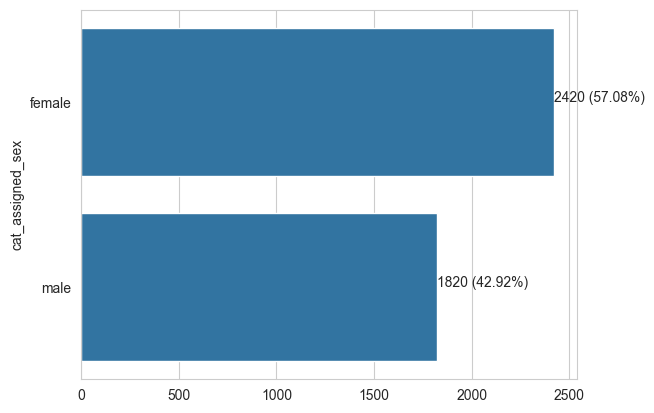

Frequencies for cat_current_smoker:
cat_current_smoker
No     2145
Yes    2095
Name: count, dtype: int64

Percentage Frequencies:
cat_current_smoker
No     50.589623
Yes    49.410377
Name: proportion, dtype: float64

NaNs: 0




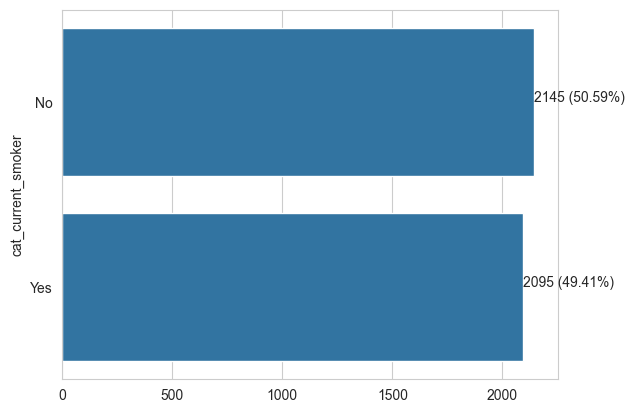

Frequencies for cat_bp_meds:
cat_bp_meds
No     4063
Yes     124
Name: count, dtype: int64

Percentage Frequencies:
cat_bp_meds
No     97.038452
Yes     2.961548
Name: proportion, dtype: float64

NaNs: 53




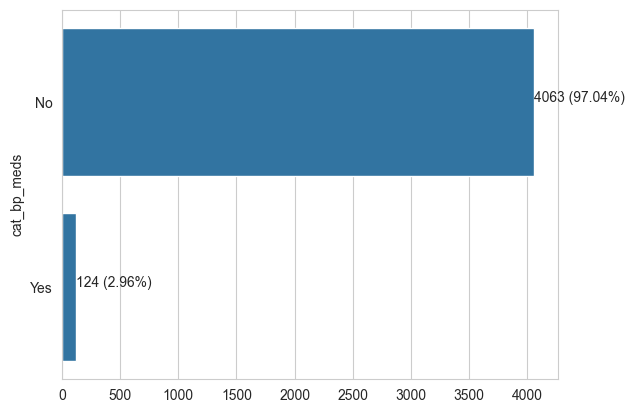

Frequencies for cat_prev_stroke:
cat_prev_stroke
No     4215
Yes      25
Name: count, dtype: int64

Percentage Frequencies:
cat_prev_stroke
No     99.410377
Yes     0.589623
Name: proportion, dtype: float64

NaNs: 0




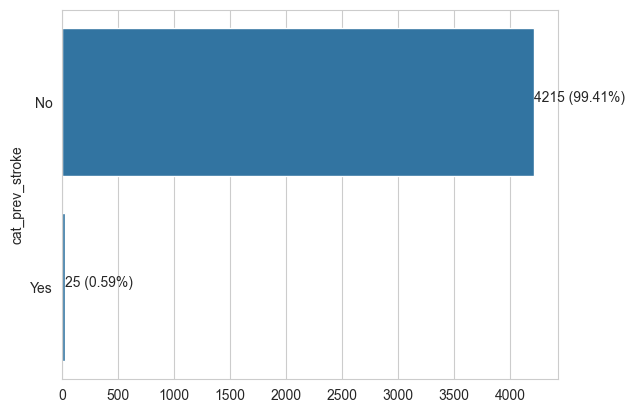

Frequencies for cat_prev_hypertense:
cat_prev_hypertense
No     2923
Yes    1317
Name: count, dtype: int64

Percentage Frequencies:
cat_prev_hypertense
No     68.938679
Yes    31.061321
Name: proportion, dtype: float64

NaNs: 0




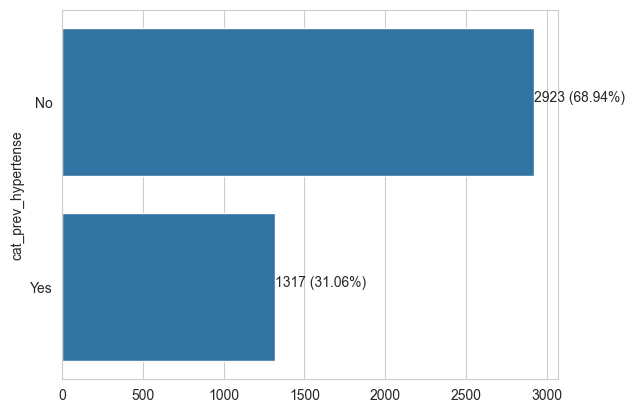

Frequencies for cat_diabetes:
cat_diabetes
No     4131
Yes     109
Name: count, dtype: int64

Percentage Frequencies:
cat_diabetes
No     97.429245
Yes     2.570755
Name: proportion, dtype: float64

NaNs: 0




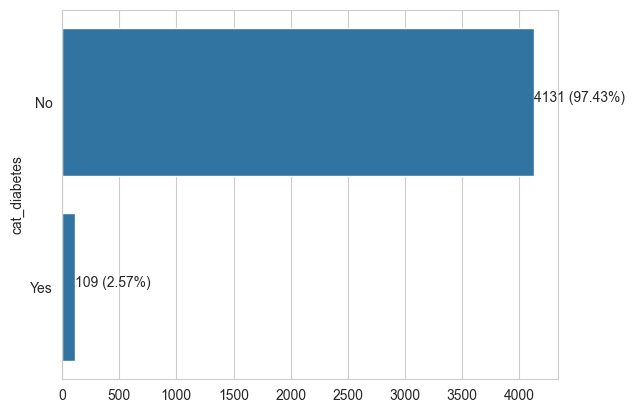

Frequencies for cat_ten_year_chd:
cat_ten_year_chd
No     3596
Yes     644
Name: count, dtype: int64

Percentage Frequencies:
cat_ten_year_chd
No     84.811321
Yes    15.188679
Name: proportion, dtype: float64

NaNs: 0




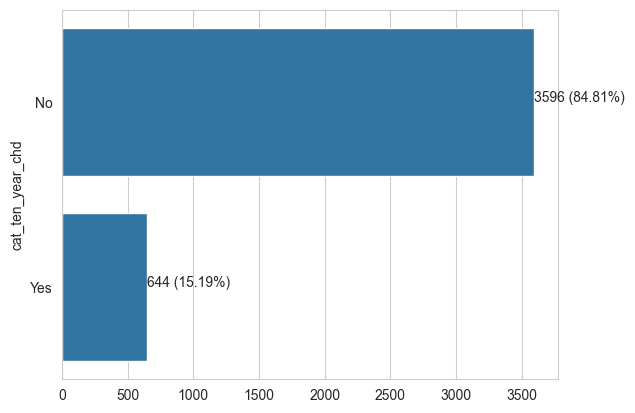

Frequencies for ord_education:
ord_education
some high school                  1720
high school/GED                   1253
some college/vocational school     689
college                            473
Name: count, dtype: int64

Percentage Frequencies:
ord_education
some high school                  41.596131
high school/GED                   30.302297
some college/vocational school    16.662636
college                           11.438936
Name: proportion, dtype: float64

NaNs: 105




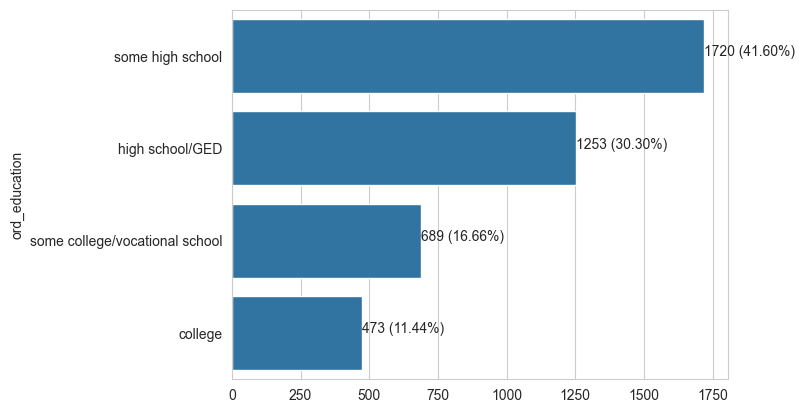

In [7]:
# Categorical variables
cat_cols = [col for col in df.columns if col.startswith('cat_')]
cat_cols.append('ord_education')

for col in cat_cols:
    freq_table = df[col].value_counts()
    freq_percent = df[col].value_counts(normalize=True) * 100

    print(f"Frequencies for {col}:")
    print(freq_table)
    print("\nPercentage Frequencies:")
    print(freq_percent)
    print(f'\nNaNs: {df[col].isna().sum()}')
    print('\n')

    sns.barplot(x=freq_table.values, y=freq_table.index, orient="h")
    for index, (count, percent) in enumerate(zip(freq_table.values, freq_percent)):
        plt.text(count, index, f'{count} ({percent:.2f}%)')
    plt.show()

## 3. Dealing with missing values
In this part, there are a lot of ways to proceed.
We follow a two step approach:
1. We drop any observation that has 2 or more missing values (this prevents introducing bias in more than one variable per observation).
2. We impute the other missing values by setting it equal to the mean conditional on assigned sex

We chose to divide the mean into male and female because some of these variables sometimes have different distributions based if the person is a male or a female.

Note: this could have been done with sklearn SimpleImputer or Imputer, but we just found out about it later in the process.

In [8]:
# NaN imputation

# Checking for NaN
print(df.isnull().sum())

# Deleting rows with multiple NaN values (in this case, it's 61)
# need to "reverse think" for the thresh argument in dropna
threshold = len(df.columns) - 1
df_clean = df.dropna(thresh = threshold, inplace=False)

# Get the mean of cigs per day of smokers
mean_cigs_per_day = df_clean[ (df_clean["cat_current_smoker"] == "Yes") & ( df_clean["cont_cigs_per_day"] > 0 ) ]["cont_cigs_per_day"].mean(skipna=True)

# Fill the NaN values of smokers with the mean, of non smokers with 0
df_clean.loc[ (df_clean["cont_cigs_per_day"].isna()) & ( df_clean["cat_current_smoker"] == "Yes") , "cont_cigs_per_day" ] =  mean_cigs_per_day
df_clean.loc[ (df_clean["cont_cigs_per_day"].isna()) & ( df_clean["cat_current_smoker"] == "No"), "cont_cigs_per_day" ] = 0

# Print just to check if operation above was completed correctly
# print(f'NaN in the dataset:\n {df_clean.isnull().sum()["cigsPerDay"]}')

"""
TODO: Fill education, BPMeds -> check how to deal with categorical nulls
"""
# Get mean BMI for male and female
mean_bmi_male = df_clean.loc[ df_clean["cat_assigned_sex"] == "male", "cont_bmi"].mean()
mean_bmi_female = df_clean.loc[ df_clean["cat_assigned_sex"] == "female", "cont_bmi"].mean()

# Fill NaN values
df_clean.loc[ ( df_clean["cat_assigned_sex"] == "male" ) & ( df_clean["cont_bmi"].isna() ), "cont_bmi"] = mean_bmi_male
df_clean.loc[ ( df_clean["cat_assigned_sex"] == "female" ) & ( df_clean["cont_bmi"].isna() ), "cont_bmi"] = mean_bmi_female

# Get mean total cholesterol
mean_total_cholesterol_male = df_clean.loc[ (df_clean["cont_total_cholesterol"].notna()) & (df_clean["cat_assigned_sex"] == "male"), "cont_total_cholesterol"].mean()
mean_total_cholesterol_female = df_clean.loc[ (df_clean["cont_total_cholesterol"].notna()) & (df_clean["cat_assigned_sex"] == "female"), "cont_total_cholesterol"].mean()

# Fill NaN values
df_clean.loc[ (df_clean["cat_assigned_sex"] == "male") & ( df_clean["cont_total_cholesterol"].isna() ), "cont_total_cholesterol"] = mean_total_cholesterol_male
df_clean.loc[ (df_clean["cat_assigned_sex"] == "female") & ( df_clean["cont_total_cholesterol"].isna() ), "cont_total_cholesterol"] = mean_total_cholesterol_female


# Get mean glucose
mean_glucose_male = df_clean.loc[ (df_clean["cont_glucose"].notna()) & (df_clean["cat_assigned_sex"] == "male"), "cont_glucose"].mean()
mean_glucose_female = df_clean.loc[ (df_clean["cont_glucose"].notna()) & (df_clean["cat_assigned_sex"] == "female"), "cont_glucose"].mean()

# Fill NaN values
df_clean.loc[ (df_clean["cat_assigned_sex"] == "male") & ( df_clean["cont_glucose"].isna() ), "cont_glucose"] = mean_glucose_male
df_clean.loc[ (df_clean["cat_assigned_sex"] == "female") & ( df_clean["cont_glucose"].isna() ), "cont_glucose"] = mean_glucose_female


# Get mean heart rate
mean_heart_rate_male = df_clean.loc[ (df_clean["cont_heart_rate"].notna()) & (df_clean["cat_assigned_sex"] == "male"), "cont_heart_rate"].mean()
mean_heart_rate_female = df_clean.loc[ (df_clean["cont_heart_rate"].notna()) & (df_clean["cat_assigned_sex"] == "female"), "cont_heart_rate"].mean()

# Fill NaN values
df_clean.loc[ (df_clean["cat_assigned_sex"] == "male") & ( df_clean["cont_heart_rate"].isna() ), "cont_heart_rate"] = mean_heart_rate_male
df_clean.loc[ (df_clean["cat_assigned_sex"] == "female") & ( df_clean["cont_heart_rate"].isna() ), "cont_heart_rate"] = mean_heart_rate_female

# Checking if NaN are corrected 
print('\n')
print(df_clean.isnull().sum())

cat_assigned_sex            0
cont_age                    0
ord_education             105
cat_current_smoker          0
cont_cigs_per_day          29
cat_bp_meds                53
cat_prev_stroke             0
cat_prev_hypertense         0
cat_diabetes                0
cont_total_cholesterol     50
cont_systolic_bp            0
cont_diastolic_bp           0
cont_bmi                   19
cont_heart_rate             1
cont_glucose              388
cat_ten_year_chd            0
dtype: int64


cat_assigned_sex           0
cont_age                   0
ord_education             93
cat_current_smoker         0
cont_cigs_per_day          0
cat_bp_meds               51
cat_prev_stroke            0
cat_prev_hypertense        0
cat_diabetes               0
cont_total_cholesterol     0
cont_systolic_bp           0
cont_diastolic_bp          0
cont_bmi                   0
cont_heart_rate            0
cont_glucose               0
cat_ten_year_chd           0
dtype: int64


Concerning categorical variables, we were in-between developing a model to predict the class and simply dropping the observations. In the end, we decided to drop them due to a couple of reasons:
1. only drops 144 extra rows
2. ca_bp_meds is really unbalanced and would therefore necessitate an extensive ML pipeline itself
3. arguably, we have not many variables that are likely to explain educational attainment

In [9]:
# categorical variables 
df_clean = df_clean.dropna(subset=(['ord_education', 'cat_bp_meds']))
df_clean = df_clean.reset_index(drop=True)
df_clean

,cat_assigned_sex,cont_age,ord_education,cat_current_smoker,cont_cigs_per_day,cat_bp_meds,cat_prev_stroke,cat_prev_hypertense,cat_diabetes,cont_total_cholesterol,cont_systolic_bp,cont_diastolic_bp,cont_bmi,cont_heart_rate,cont_glucose,cat_ten_year_chd
0,male,39,college,No,0.0,No,No,No,No,195.0,106.0,70.0,26.97,80.0,77.000000,No
1,female,46,high school/GED,No,0.0,No,No,No,No,250.0,121.0,81.0,28.73,95.0,76.000000,No
2,male,48,some high school,Yes,20.0,No,No,No,No,245.0,127.5,80.0,25.34,75.0,70.000000,No
3,female,61,some college/vocational school,Yes,30.0,No,No,Yes,No,225.0,150.0,95.0,28.58,65.0,103.000000,Yes
4,female,46,some college/vocational school,Yes,23.0,No,No,No,No,285.0,130.0,84.0,23.10,85.0,85.000000,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4030,male,51,some college/vocational school,Yes,43.0,No,No,No,No,207.0,126.5,80.0,19.71,65.0,68.000000,No
4031,female,44,some high school,Yes,15.0,No,No,No,No,210.0,126.5,87.0,19.16,86.0,81.830848,No
4032,female,52,high school/GED,No,0.0,No,No,No,No,269.0,133.5,83.0,21.47,80.0,107.000000,No
4033,male,40,some college/vocational school,No,0.0,No,No,Yes,No,185.0,141.0,98.0,25.60,67.0,72.000000,No


# 4. SMOTE-NC + Undersampling
- Given the fact that the target variable is pretty unbalanced, we decided to use SMOTE to oversample the minority class and undersample the majority class.
- We are following a similar approach as in TP1, using a combination of SMOTE-NC and random under-sampling
- Because the features in our case are composed of both continuous and categorical feature, we have to use the SMOTE-NC version (SMOTE for categorical and continuous variables). Link: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC
- About test data size: this was an arbitrary value, we could have used a different one. We chose to use 0.2 because it is a common value used in the literature. Link: https://medium.com/@nahmed3536/the-motivation-for-train-test-split-2b1837f596c3
- We have tested the entire ML pipeline without the this *SMOTE-NC + Undersampling* step and the models performed much worse.

In [10]:
# Remove target variable from the dataset
X = df_clean.drop(columns=["cat_ten_year_chd"])
y = df_clean["cat_ten_year_chd"]

# Split into train and test data
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.2, random_state=random_state) # TODO: adjust test size

In [11]:
counts = Counter(y_train_org)
print(counts)
print(f"Minority class ratio before SMOTENC: {np.round(counts['Yes'] / (counts['Yes'] + counts['No']), 4) * 100}%")

cat_features = [x for x in cat_cols if x != 'cat_ten_year_chd']

# SMOTENC
sm = over_sampling.SMOTENC(sampling_strategy=0.2, random_state=random_state, categorical_features=cat_features)
X_train_res, y_train_res = sm.fit_resample(X_train_org, y_train_org)

counts = Counter(y_train_res)
print(counts)
print(f"Minority class ratio after SMOTENC: {np.round(counts['Yes'] / (counts['Yes'] + counts['No']), 4) * 100}%")

# Undersampling
random_under = under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state=random_state)
X_train_sample , y_train_sample = random_under.fit_resample(X_train_res, y_train_res)

counts = Counter(y_train_sample)
print(counts)
print(f"Minority class ratio after SMOTENC & random undersampling: {np.round(counts['Yes'] / (counts['Yes'] + counts['No']), 4) * 100}%")

train_data_sample = pd.concat([X_train_sample, y_train_sample], axis=1)
test_data = pd.concat([X_test_org, y_test_org], axis=1)
full_data = pd.concat([train_data_sample, test_data], axis=0)

Counter({'No': 2762, 'Yes': 466})
Minority class ratio before SMOTENC: 14.44%
Counter({'No': 2762, 'Yes': 552})
Minority class ratio after SMOTENC: 16.66%
Counter({'No': 1104, 'Yes': 552})
Minority class ratio after SMOTENC & random undersampling: 33.33%


/Users/tildietrich/Library/CloudStorage/OneDrive-Personal/ulisboa/1-semester/advanced-ml/Project1-AAA/python-aml/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# 5. Create categorical features from continuous features
In order to do Structure Learning and Parameter Learning in a Bayesian Network with pgmpy, it is necessary to have either only categorical or only continuous variables. Hybrid Bayesian Networks are not supported. Because of this, in combination with the fact that not all functionalities of the pgmpy library work with fully continuous Bayesian Networka and we have many categorical features, we decide to categorize the continuous features at hand.

We choose to do this after after the over-sampling and the under-sampling so we keep the most information possible in the sampling process, and just lose information in the last step (categorization).

As we think that this categorization has a considerable impact on the model, we decide to test two different categorization, the first being:
Each continuous variable is divided following orientations from clinical literature. Below, follow the links referring to each variable:
- age: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3825015/
- cigarettes per day: https://cancercontrol.cancer.gov/sites/default/files/2020-08/m15_7.pdf
- total cholesterol: https://my.clevelandclinic.org/health/articles/11920-cholesterol-numbers-what-do-they-mean
- blood pressure: https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings
- bmi: https://www.ncbi.nlm.nih.gov/books/NBK541070/
The nice thing about this approach is that the queries are easily explainable to a medical professional.

The second one is dividing each variable into quintiles and work with the resulting categories. 


### 5.1. Categorization through domain knowledge

In [12]:
# define function for categorization
def convert_to_categorical(df, cont_col, cat_col, cutoffs, categories) -> pd.DataFrame:
    """
    Converts a continuous column in a dataframe to categorical based on provided cutoffs and categories.
    
    Parameters:
    - pandas_df (pd.DataFrame): The input dataframe
    - cont_col (str): Name of the continuous column to be converted
    - cat_col (str): Name of the new categorical column
    - cutoffs (list): List of cutoff values for categorization
    - categories (list): List of category names
    
    Returns:
    - pd.DataFrame: Updated dataframe
    """
    
    df[cat_col] = pd.cut(df[cont_col], bins=cutoffs, labels=categories, right=False)
    df = df.drop(columns=[cont_col])
    
    return df

# for pre-smotenc
#train_data_org = pd.concat([X_train_org, y_train_org], axis=1)
#test_data = pd.concat([X_test_org, y_test_org], axis=1)

#train_data_cat= train_data_org.copy()
#test_data_cat = test_data.copy()
#full_data_cat = df_clean.copy()


# for post-smotenc
train_data_cat = train_data_sample.copy()
test_data_cat = test_data.copy()
full_data_cat = full_data.copy()

datasets = [train_data_cat, test_data_cat, full_data_cat]

# age groups
age_cutoffs = [full_data_cat['cont_age'].min(), 40, 50, 60, full_data_cat['cont_age'].max()+1]
age_categories = ["32-39", "40-49", "50-59", "60-70"]

for idx, dataset in enumerate(datasets):
    datasets[idx] = convert_to_categorical(dataset, "cont_age", "cat_age", age_cutoffs, age_categories)
train_data_cat, test_data_cat, full_data_cat = datasets

print(full_data_cat['cat_age'].value_counts(normalize=True))

# cigarettes per day groups
cigs_per_day_cutoffs = [full_data_cat['cont_cigs_per_day'].min(), 1, 5, 15, 25, full_data_cat['cont_cigs_per_day'].max()+1]
cigs_per_day_categories = ["None", "1-5", "5-14", "15-24", "More than 25"]
for idx, dataset in enumerate(datasets):
    datasets[idx] = convert_to_categorical(dataset, "cont_cigs_per_day", "cat_cigs_per_day", cigs_per_day_cutoffs, cigs_per_day_categories)
train_data_cat, test_data_cat, full_data_cat = datasets

print(full_data_cat['cat_cigs_per_day'].value_counts(normalize=True))

# total cholesterol (mg/dL) groups
# we can use these numbers as we have no minors in our sample
total_cholesterol_cutoffs = [full_data_cat['cont_total_cholesterol'].min(), 200, 240, full_data_cat['cont_total_cholesterol'].max()+1]
total_cholesterol_categories = ["Normal (<200)", "Boarderline High (200-239)", "High (>=240)"]
for idx, dataset in enumerate(datasets):
    datasets[idx] = convert_to_categorical(dataset, "cont_total_cholesterol", "cat_total_cholesterol", total_cholesterol_cutoffs, total_cholesterol_categories)
train_data_cat, test_data_cat, full_data_cat = datasets

print(full_data_cat['cat_total_cholesterol'].value_counts(normalize=True))

# On Blood pressure: usually the two types of pressure are combined but as we would like to identify underlying patterns, we will keep them separate

# systolic blood pressure groups
systolic_bp_cutoffs = [full_data_cat['cont_systolic_bp'].min(), 120, 130, 140, 180, full_data_cat['cont_systolic_bp'].max()+1]
systolic_bp_categories = ["<120 mm HG", "120-129 mm HG", "130-139 mm HG", "140-179 mm HG", ">=180 mm HG"]
for idx, dataset in enumerate(datasets):
    datasets[idx] = convert_to_categorical(dataset, "cont_systolic_bp", "cat_systolic_bp", systolic_bp_cutoffs, systolic_bp_categories)
train_data_cat, test_data_cat, full_data_cat = datasets

print(full_data_cat['cat_systolic_bp'].value_counts(normalize=True))

# diastolic blood pressure groups
diastolic_bp_cutoffs = [full_data_cat['cont_diastolic_bp'].min(), 80, 90, 120, full_data_cat['cont_diastolic_bp'].max()+1]
diastolic_bp_categories = ["<80 mm HG", "80-89 mm HG", "90-119 mm HG", ">=120 mm HG"]
for idx, dataset in enumerate(datasets):
    datasets[idx] = convert_to_categorical(dataset, "cont_diastolic_bp", "cat_diastolic_bp", diastolic_bp_cutoffs, diastolic_bp_categories)
train_data_cat, test_data_cat, full_data_cat = datasets

print(full_data_cat['cat_diastolic_bp'].value_counts(normalize=True))

# bmi groups
# bmi is not an uncontested measure, especially when putting it into groups with labels in can be quite one-dimensional but as we are using it together with other groups it shuold be ok
bmi_cutoffs = [full_data_cat['cont_bmi'].min(), 18.5, 25, 30, 35, full_data_cat['cont_bmi'].max()+1]
bmi_categories = ["Underweight (<18.5 kg/m^2)", "Normal weight (18.5-24.9 kg/m^2)", "Overweight (25-29.9 kg/m^2)", "Obesity class I (30-34.9 kg/m^2)", "Obesity class II or III (>= 35 kg/m^2)"]
for idx, dataset in enumerate(datasets):
    datasets[idx] = convert_to_categorical(dataset, "cont_bmi", "cat_bmi", bmi_cutoffs, bmi_categories)
train_data_cat, test_data_cat, full_data_cat = datasets

print(full_data_cat['cat_bmi'].value_counts(normalize=True))

# heart rate groups, 
# Again, heart rate groups differ greatly between individuals and are often expressed in % of max heart rate instead of absolute values, we still group here
heart_rate_cutoffs = [full_data_cat['cont_heart_rate'].min(), 60, 70, 85, 100, full_data_cat['cont_heart_rate'].max()+1]
heart_rate_categories = ["<60 bpm", "60-69 bpm", "70-84 bpm", "85-99 bpm", ">=100 bpm"]
for idx, dataset in enumerate(datasets):
    datasets[idx] = convert_to_categorical(dataset, "cont_heart_rate", "cat_heart_rate", heart_rate_cutoffs, heart_rate_categories)
train_data_cat, test_data_cat, full_data_cat = datasets

print(full_data_cat['cat_heart_rate'].value_counts(normalize=True))

# glucose level groups, assuming a fasting glucose measure as typical
glucose_cutoffs = [full_data_cat['cont_glucose'].min(), 100, 125, full_data_cat['cont_glucose'].max()+1]
glucose_categories = ["<100 mg/dL", "100-124 mg/dL", ">=125 mg/dL"]
for idx, dataset in enumerate(datasets):
    datasets[idx] = convert_to_categorical(dataset, "cont_glucose", "cat_glucose", glucose_cutoffs, glucose_categories)
train_data_cat, test_data_cat, full_data_cat = datasets

print(full_data_cat['cat_glucose'].value_counts(normalize=True))


cat_age
40-49    0.364596
50-59    0.333333
60-70    0.184734
32-39    0.117337
Name: proportion, dtype: float64
cat_cigs_per_day
None            0.493707
15-24           0.241575
More than 25    0.113276
5-14            0.102314
1-5             0.049127
Name: proportion, dtype: float64
cat_total_cholesterol
High (>=240)                  0.465692
Boarderline High (200-239)    0.349168
Normal (<200)                 0.185140
Name: proportion, dtype: float64
cat_systolic_bp
140-179 mm HG    0.288266
<120 mm HG       0.274868
120-129 mm HG    0.221681
130-139 mm HG    0.166058
>=180 mm HG      0.049127
Name: proportion, dtype: float64
cat_diastolic_bp
<80 mm HG       0.372310
80-89 mm HG     0.356882
90-119 mm HG    0.258628
>=120 mm HG     0.012180
Name: proportion, dtype: float64
cat_bmi
Overweight (25-29.9 kg/m^2)               0.434024
Normal weight (18.5-24.9 kg/m^2)          0.422249
Obesity class I (30-34.9 kg/m^2)          0.103532
Obesity class II or III (>= 35 kg/m^2)    0.025579

In [13]:
full_data_cat.columns

Index(['cat_assigned_sex', 'ord_education', 'cat_current_smoker',
       'cat_bp_meds', 'cat_prev_stroke', 'cat_prev_hypertense', 'cat_diabetes',
       'cat_ten_year_chd', 'cat_age', 'cat_cigs_per_day',
       'cat_total_cholesterol', 'cat_systolic_bp', 'cat_diastolic_bp',
       'cat_bmi', 'cat_heart_rate', 'cat_glucose'],
      dtype='object')

In [14]:
train_data_sample

,cat_assigned_sex,cont_age,ord_education,cat_current_smoker,cont_cigs_per_day,cat_bp_meds,cat_prev_stroke,cat_prev_hypertense,cat_diabetes,cont_total_cholesterol,cont_systolic_bp,cont_diastolic_bp,cont_bmi,cont_heart_rate,cont_glucose,cat_ten_year_chd
520,female,45,high school/GED,No,0.000000,No,No,No,No,229.000000,130.000000,80.000000,21.720000,75.000000,77.000000,No
1970,female,41,high school/GED,No,0.000000,No,No,No,No,277.000000,113.500000,75.000000,29.730000,63.000000,90.000000,No
1965,male,55,high school/GED,Yes,20.000000,No,No,No,No,283.000000,137.000000,82.000000,28.490000,75.000000,85.000000,No
1009,female,44,some high school,No,0.000000,No,No,No,No,219.000000,129.000000,90.000000,33.470000,88.000000,73.000000,No
2519,female,40,some college/vocational school,No,0.000000,No,No,No,No,240.000000,108.000000,72.000000,17.640000,78.000000,81.830848,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,female,40,high school/GED,Yes,14.788106,No,No,No,No,220.652540,134.093187,89.305081,25.220700,94.652540,73.127136,Yes
3310,male,65,some high school,Yes,10.735873,No,No,No,No,227.831143,112.341984,71.389619,24.207596,84.632064,60.316032,Yes
3311,male,42,some high school,Yes,27.792081,No,No,No,No,241.324752,135.376731,96.285644,27.816169,83.792081,71.233665,Yes
3312,male,64,some high school,Yes,33.549907,No,No,Yes,No,221.805084,146.709981,77.740112,29.108249,77.099814,91.389833,Yes


### 5.2. Quintile categorization

In [15]:
# function to convert to deciles
def convert_to_quintiles(df, cont_col, cat_col):
    """
    Converts a continuous column in a dataframe to deciles.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe
    - cont_col (str): Name of the continuous column to be converted
    - cat_col (str): Name of the new decile column
    
    Returns:
    - pd.DataFrame: Updated dataframe
    """

    # Check if the column exists in the dataframe
    if cont_col not in df.columns:
        return df

    # First, get the bins without labels
    df[cat_col], bins = pd.qcut(df[cont_col], q=5, retbins=True, duplicates='drop')

    # Then, create labels for the number of bins we have
    n_bins = len(bins) - 1
    labels = [f"Quintile {i}" for i in range(1, n_bins + 1)]

    # Now, use `pd.cut()` to re-bin the data with our labels
    df[cat_col] = pd.cut(df[cont_col], bins=bins, labels=labels, include_lowest=True)

    df = df.drop(columns=[cont_col])
    
    return df

# use different names
train_data_quintiles = train_data_sample.copy()
test_data_quintiles = test_data.copy()
full_data_quintiles = full_data.copy()

# Assuming your datasets and columns are already loaded from the previous code
datasets = [train_data_quintiles, test_data_quintiles, full_data_quintiles]
cols_to_convert = ['cont_age', 'cont_cigs_per_day', 'cont_total_cholesterol', 'cont_systolic_bp', 'cont_diastolic_bp', 'cont_bmi', 'cont_heart_rate', 'cont_glucose']

# Convert each column into quintiles
for col in cols_to_convert:
    cat_col_name = "quintile_" + col.split("_", 1)[1]
    for idx, dataset in enumerate(datasets):
        datasets[idx] = convert_to_quintiles(dataset, col, cat_col_name)
    train_data_quintiles, test_data_quintiles, full_data_quintiles = datasets
    print(full_data_quintiles[cat_col_name].value_counts(normalize=True))


quintile_age
Quintile 1    0.235079
Quintile 3    0.209907
Quintile 4    0.194072
Quintile 5    0.184734
Quintile 2    0.176208
Name: proportion, dtype: float64
quintile_cigs_per_day
Quintile 1    0.606171
Quintile 2    0.277304
Quintile 3    0.116525
Name: proportion, dtype: float64
quintile_total_cholesterol
Quintile 3    0.208283
Quintile 1    0.203410
Quintile 2    0.200162
Quintile 5    0.199350
Quintile 4    0.188794
Name: proportion, dtype: float64
quintile_systolic_bp
Quintile 2    0.205035
Quintile 1    0.201380
Quintile 5    0.199350
Quintile 4    0.198538
Quintile 3    0.195696
Name: proportion, dtype: float64
quintile_diastolic_bp
Quintile 2    0.227365
Quintile 1    0.203816
Quintile 5    0.198132
Quintile 4    0.192854
Quintile 3    0.177832
Name: proportion, dtype: float64
quintile_bmi
Quintile 1    0.201786
Quintile 3    0.201380
Quintile 4    0.199350
Quintile 5    0.199350
Quintile 2    0.198132
Name: proportion, dtype: float64
quintile_heart_rate
Quintile 1    0.2099

## 6. Structure Learning
In order to do structure learning, we decided to use **Hill Climb Search**. It is a greedy algorithm (which means it can get stuck in local optima), nevertheless it is a **very fast algorithm** for the size of our dataset. We also tried Exhaustive Search, but for the number of variables in question, it is impractical to use it.

Here, the objective is to obtain a **DAG** (Directed Acyclic Graph) that represents the causal relationships between the variables

The code to visualize a network, get f1 score and initialize a random graph is taken from the notebooks given for the TP classes.

In [16]:
# Code to visualize the network
def visualize_network(G):
  # G must be a DAG
  pos = nx.circular_layout(G)
  nx.draw(G, node_color='#00b4d9', pos=pos, with_labels=True)
  #nx.draw(model, with_labels=True)
  plt.show()

In [17]:
def get_f1_score(estimated_model, true_model):
  # estimated_model and model must be DAGs
  nodes = estimated_model.nodes()
  est_adj = nx.to_numpy_array(
    estimated_model.to_undirected(), nodelist=nodes, weight=None
  )
  true_adj = nx.to_numpy_array(
    true_model.to_undirected(), nodelist=nodes, weight=None
  )

  f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
  print("F1-score for the model skeleton: ", f1)

In [18]:
# generalized function to initialize graph
def initialize_graph(nodes, p=1):
  G = DAG()
  G.add_nodes_from(nodes=nodes)
  init = G.get_random(n_nodes=len(nodes), edge_prob=p)
  ls = []
  mapping = {i: node for i, node in enumerate(nodes)}
  for i,j in init.edges:
    ls.append((mapping[i],mapping[j]))
  ls
  G.add_edges_from(ebunch=ls) # G is the required initialization for the Hill Climbing method
  return G

## Hill Climb Search
Given the fact that Hill Climb Search is a **greedy algorithm** and is **sensitive to the starting conditions** (in this case, the starting DAG), we chose to run it multiple times with random DAG's in order to get the best fit.

We also chose to try different scoring metrics in order to get the best DAG possible. The metrics we tried are:
- BDeu
- K2
- Bic

Note: the structure learning takes **A LOT** of time to run!

In [19]:
# random seed in same context
random.seed(random_state)
np.random.seed(random_state)


# hill climb usually reacts strongly to different configurations of the initial DAG
# Therefore, we go through some initial random initializations, including no links and full links
def structure_learning(df, num_start_links=10):

    # random starting dag
    start_dag_links = [random.random() for _ in range(num_start_links)]
    start_dag_links.insert(0, 0)
    start_dag_links.append(1)
    start_dag_links.sort()

    # initialize list of nodes
    nodes = df.columns

    # initialize scores
    bdeu = BDeuScore(df, equivalent_sample_size=6)
    k2 = K2Score(df)
    bic = BicScore(df)
    
    results_models = {
        "bdeu": {"model": None, "score": -np.inf, "start_dag_link": None}, 
        "k2": {"model": None, "score": -np.inf, "start_dag_link": None}, 
        "bic": {"model": None, "score": -np.inf, "start_dag_link": None}
    }

    for method, name in zip([bdeu,k2,bic], ["bdeu","k2","bic"]):
        for start_dag_link in start_dag_links:
            
            # starting dag
            random_dag = initialize_graph(nodes, start_dag_link)

            hc = HillClimbSearch(df)
            best_model = hc.estimate(scoring_method=method, start_dag=random_dag)
            model_score = method.score(best_model)

            # Save both model and its score
            if model_score > results_models[name]["score"]:
                results_models[name]["model"] = best_model
                results_models[name]["score"] = model_score
                results_models[name]["start_dag_link"] = start_dag_link

            print(f'Method: {name} | Score: {model_score} | PercInitialLinks: {np.round(start_dag_link, 4)*100}% | BestModel: {best_model.edges()}')
    return results_models


best_models_results = structure_learning(full_data_cat)

  0%|          | 24/1000000 [00:02<31:11:15,  8.91it/s]


Method: bdeu | Score: -28561.661764479788 | PercInitialLinks: 0% | BestModel: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'ord_education'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_ten_year_chd', 'cat_cigs_per_day'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_prev_stroke'), ('cat_glucose',

  0%|          | 24/1000000 [00:02<30:52:31,  9.00it/s]


Method: bdeu | Score: -28561.661764479788 | PercInitialLinks: 1.8399999999999999% | BestModel: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'ord_education'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_ten_year_chd', 'cat_cigs_per_day'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_prev_stroke')

  0%|          | 21/1000000 [00:02<30:27:58,  9.12it/s]


Method: bdeu | Score: -28628.728908405836 | PercInitialLinks: 2.63% | BestModel: [('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'ord_education'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_cigs_per_day'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_current_smoker'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_age', 'cat_systolic_bp'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_total_cholesterol', 'cat_age'), ('cat_systolic_bp', 'cat_diastolic_bp'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_prev_stroke'), ('cat_glucose', 'cat_diabetes')]


  0%|          | 25/1000000 [00:02<28:43:14,  9.67it/s]


Method: bdeu | Score: -28630.96445394019 | PercInitialLinks: 3.02% | BestModel: [('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'ord_education'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_ten_year_chd', 'cat_cigs_per_day'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_total_cholesterol', 'cat_systolic_bp'), ('cat_systolic_bp', 'cat_diastolic_bp'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_prev_stroke'), ('cat_glucose', 'cat_diabetes')]


  0%|          | 25/1000000 [00:02<29:07:33,  9.54it/s]


Method: bdeu | Score: -28567.950431276564 | PercInitialLinks: 9.56% | BestModel: [('cat_assigned_sex', 'cat_diabetes'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'ord_education'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_cigs_per_day'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'c

  0%|          | 47/1000000 [00:04<25:45:52, 10.78it/s]


Method: bdeu | Score: -28644.278329595476 | PercInitialLinks: 27.26% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('ord_education', 'cat_prev_hypertense'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_diabetes'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_current_smoker'), ('cat_systolic_bp', 'cat_bmi'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastoli

  0%|          | 50/1000000 [00:04<24:46:31, 11.21it/s]


Method: bdeu | Score: -28596.776886744734 | PercInitialLinks: 32.550000000000004% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_prev_hypertense'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'cat_bp_meds'), ('ord_education', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_systolic_bp'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_ten_year_chd', 'cat_prev_stroke'), ('cat_age', 'cat_prev_hypertense'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'cat_total_chole

  0%|          | 79/1000000 [00:14<51:48:11,  5.36it/s] 


Method: bdeu | Score: -28637.219807946985 | PercInitialLinks: 65.64% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_diastolic_bp'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_age'), ('cat_ten_year_chd', 'cat_diastolic_bp'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_ten_year_chd', 'cat_prev_hypertense'), ('cat_ten_year_chd', 'cat_bp_meds'), ('cat_ten_year_chd', 'cat_prev_stroke'), ('cat_age', 'cat_total_cholesterol'), 

  0%|          | 71/1000000 [00:09<35:25:45,  7.84it/s]


Method: bdeu | Score: -28635.024958086058 | PercInitialLinks: 66.36999999999999% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_assigned_sex', 'cat_prev_hypertense'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_current_smoker', 'cat_prev_hypertense'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_systolic_bp'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_age'), ('cat_ten_ye

  0%|          | 72/1000000 [07:09<1658:21:25,  5.97s/it] 


Method: bdeu | Score: -33682.54329778218 | PercInitialLinks: 78.14% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'cat_glucose'), ('cat_assigned_sex', 'cat_heart_rate'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('ord_education', 'cat_heart_rate'), ('ord_education', 'cat_glucose'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_current_smoker', 'cat_age'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_ten_year_chd'), ('cat_bp_meds', 'cat_systolic_bp'), ('cat_bp_meds', 'cat_glucose'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense

  0%|          | 81/1000000 [07:23<1522:02:11,  5.48s/it] 


Method: bdeu | Score: -33749.77661038439 | PercInitialLinks: 99.83% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'cat_heart_rate'), ('cat_assigned_sex', 'cat_glucose'), ('ord_education', 'cat_heart_rate'), ('ord_education', 'cat_glucose'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'cat_systolic_bp'), ('cat_bp_meds', 'cat_glucose'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_total_cholesterol'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_p

  0%|          | 81/1000000 [07:21<1512:25:50,  5.45s/it] 


Method: bdeu | Score: -33749.77661038439 | PercInitialLinks: 100% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'cat_heart_rate'), ('cat_assigned_sex', 'cat_glucose'), ('ord_education', 'cat_heart_rate'), ('ord_education', 'cat_glucose'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'cat_systolic_bp'), ('cat_bp_meds', 'cat_glucose'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_total_cholesterol'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_pre

  0%|          | 24/1000000 [00:02<28:46:33,  9.65it/s]


Method: k2 | Score: -28494.141709132844 | PercInitialLinks: 0% | BestModel: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('cat_ten_year_chd', 'cat_diabetes'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_age', 'cat_cigs_per_day'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_heart_rate'), ('cat_bmi', 'cat_diastolic_bp'), ('cat_bmi', 'cat_assigned_sex')]


  0%|          | 26/1000000 [00:02<27:29:39, 10.10it/s]


Method: k2 | Score: -28507.3639665648 | PercInitialLinks: 1.8399999999999999% | BestModel: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_current_smoker', 'cat_age'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_cigs_per_day'), ('cat_diabetes', 'cat_glucose'), ('cat_diabetes', 'cat_ten_year_chd'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_heart_rate'), ('cat_diastolic_bp', 'cat_bmi'), (

  0%|          | 27/1000000 [00:02<26:43:56, 10.39it/s]


Method: k2 | Score: -28490.745832715318 | PercInitialLinks: 2.63% | BestModel: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_age', 'cat_cigs_per_day'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_heart_rate'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_bmi', 'cat_assigned_sex'), ('cat_heart_rate', 'cat_ass

  0%|          | 35/1000000 [00:02<23:48:15, 11.67it/s]


Method: k2 | Score: -28490.28430673492 | PercInitialLinks: 3.02% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_heart_rate'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_current_smoker', 'cat_assigned_sex'), ('cat_prev_stroke', 'cat_assigned_sex'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('cat_ten_year_chd', 'cat_current_smoker'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'ord_education'), ('cat_age', 'cat_total_cholesterol'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_systolic_bp'

  0%|          | 30/1000000 [00:02<25:14:54, 11.00it/s]


Method: k2 | Score: -28526.44241702868 | PercInitialLinks: 9.56% | BestModel: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_heart_rate'), ('cat_current_smoker', 'cat_diastolic_bp'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_assigned_sex'), ('cat_prev_stroke', 'cat_diastolic_bp'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_d

  0%|          | 48/1000000 [00:04<23:11:53, 11.97it/s]


Method: k2 | Score: -28560.764406609218 | PercInitialLinks: 27.26% | BestModel: [('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_heart_rate'), ('ord_education', 'cat_assigned_sex'), ('ord_education', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'cat_assigned_sex'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'ord_education'), ('cat_diabetes', 'cat_current_smoker'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_current_smoker'), ('cat_systolic_bp', 'cat_age'), ('cat_dias

  0%|          | 41/1000000 [00:03<25:06:50, 11.06it/s]


Method: k2 | Score: -28512.717945695123 | PercInitialLinks: 32.550000000000004% | BestModel: [('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'ord_education'), ('cat_current_smoker', 'cat_age'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_diastolic_bp'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_cigs_per_day'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_systolic_

  0%|          | 73/1000000 [00:10<40:18:39,  6.89it/s] 


Method: k2 | Score: -28566.170082151733 | PercInitialLinks: 65.64% | BestModel: [('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_prev_hypertense'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_heart_rate'), ('ord_education', 'cat_assigned_sex'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_age'), ('cat_prev_stroke', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_diabetes', 'cat_glucose'), ('cat_diabetes', 'cat_current_smoker'), ('cat_ten_year_chd', 'cat_diabetes'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_prev_hypertense'), ('cat_age', 'cat_current_smoker'),

  0%|          | 72/1000000 [00:09<35:47:50,  7.76it/s] 


Method: k2 | Score: -28616.607632859523 | PercInitialLinks: 66.36999999999999% | BestModel: [('cat_assigned_sex', 'cat_prev_hypertense'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_heart_rate'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_bmi'), ('ord_education', 'cat_assigned_sex'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'cat_ten_year_chd'), ('cat_bp_meds', 'cat_assigned_sex'), ('cat_bp_meds', 'cat_age'), ('cat_prev_stroke', 'cat_age'), ('cat_prev_stroke', 'cat_diastolic_bp'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_stroke', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_diabetes', 'cat

  0%|          | 71/1000000 [00:18<73:35:20,  3.77it/s] 


Method: k2 | Score: -28563.499707390834 | PercInitialLinks: 78.14% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'cat_ten_year_chd'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_ten_year_chd'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'cat_ten_year_chd'), ('cat_diabetes', 'cat_glucose'), ('cat_diabetes', 'ca

  0%|          | 107/1000000 [07:27<1162:23:49,  4.19s/it]


Method: k2 | Score: -28531.646555317562 | PercInitialLinks: 99.83% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_ten_year_chd'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'cat_ten_year_chd'), ('cat_diabetes', 'cat_glucose'), ('cat_diabetes', 'cat_current_smoker'), ('cat_ten_year_chd', 'cat_age'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'

  0%|          | 108/1000000 [09:10<1414:34:35,  5.09s/it]


Method: k2 | Score: -28531.646555317562 | PercInitialLinks: 100% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_ten_year_chd'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'cat_ten_year_chd'), ('cat_diabetes', 'cat_glucose'), ('cat_diabetes', 'cat_current_smoker'), ('cat_ten_year_chd', 'cat_age'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'),

  0%|          | 18/1000000 [00:01<29:35:21,  9.39it/s]


Method: bic | Score: -28700.88823130207 | PercInitialLinks: 0% | BestModel: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_bmi', 'cat_diastolic_bp'), ('cat_glucose', 'cat_diabetes')]


  0%|          | 16/1000000 [00:01<31:20:28,  8.86it/s]


Method: bic | Score: -28830.384300986167 | PercInitialLinks: 1.8399999999999999% | BestModel: [('cat_prev_hypertense', 'cat_cigs_per_day'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_total_cholesterol', 'cat_diastolic_bp'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_glucose', 'cat_diabetes')]


  0%|          | 23/1000000 [00:02<26:19:28, 10.55it/s]


Method: bic | Score: -28712.654042473794 | PercInitialLinks: 2.63% | BestModel: [('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_current_smoker', 'cat_bmi'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_bmi', 'cat_diastolic_bp'), ('cat_glucose', 'cat_diabetes')]


  0%|          | 21/1000000 [00:02<27:02:15, 10.27it/s]


Method: bic | Score: -28783.33387807686 | PercInitialLinks: 3.02% | BestModel: [('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_current_smoker', 'cat_age'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_age'), ('cat_ten_year_chd', 'cat_diastolic_bp'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_glucose', 'cat_diabetes')]


  0%|          | 25/1000000 [00:02<26:29:13, 10.49it/s]


Method: bic | Score: -28705.14244900191 | PercInitialLinks: 9.56% | BestModel: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_prev_stroke', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_age', 'cat_current_smoker'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_glucose', 'cat_diabetes')]


  0%|          | 47/1000000 [00:04<25:41:17, 10.81it/s]


Method: bic | Score: -28746.53053367467 | PercInitialLinks: 27.26% | BestModel: [('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_age'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_systolic_bp', 'cat_diastolic_bp'), ('cat_bmi', 'cat_assigned_sex')]


  0%|          | 51/1000000 [00:04<23:54:16, 11.62it/s]


Method: bic | Score: -28767.057101649287 | PercInitialLinks: 32.550000000000004% | BestModel: [('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_bmi'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_prev_hypertense'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_diabetes', 'cat_glucose'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_current_smoker'), ('cat_diastolic_bp', 'cat_systolic_bp')]


  0%|          | 85/1000000 [00:50<166:32:50,  1.67it/s] 


Method: bic | Score: -28772.58858880983 | PercInitialLinks: 65.64% | BestModel: [('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_bmi'), ('ord_education', 'cat_assigned_sex'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_total_cholesterol'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'ord_education'), ('cat_total_cholesterol', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp')]


  0%|          | 74/1000000 [00:08<31:48:17,  8.73it/s]


Method: bic | Score: -28775.18030882647 | PercInitialLinks: 66.36999999999999% | BestModel: [('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_current_smoker', 'cat_age'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_age'), ('cat_ten_year_chd', 'cat_prev_hypertense'), ('cat_ten_year_chd', 'cat_bp_meds'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'ord_education'), ('cat_diastolic_bp', 'cat_sy

  0%|          | 85/1000000 [00:56<183:25:38,  1.51it/s] 


Method: bic | Score: -28824.70024667038 | PercInitialLinks: 78.14% | BestModel: [('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_current_smoker', 'cat_age'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_total_cholesterol'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_age'), ('cat_age', 'ord_education'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_bmi', 'cat_assigned_sex')]


  0%|          | 105/1000000 [06:25<1019:48:15,  3.67s/it]


Method: bic | Score: -28824.70024667038 | PercInitialLinks: 99.83% | BestModel: [('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_total_cholesterol'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_age'), ('cat_age', 'ord_education'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_bmi', 'cat_assigned_sex')]


  0%|          | 105/1000000 [06:23<1014:50:48,  3.65s/it]


Method: bic | Score: -28824.70024667038 | PercInitialLinks: 100% | BestModel: [('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'cat_cigs_per_day'), ('cat_current_smoker', 'cat_age'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_age'), ('cat_prev_hypertense', 'cat_total_cholesterol'), ('cat_prev_hypertense', 'cat_systolic_bp'), ('cat_prev_hypertense', 'cat_diastolic_bp'), ('cat_prev_hypertense', 'cat_bmi'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'cat_glucose'), ('cat_ten_year_chd', 'cat_age'), ('cat_age', 'ord_education'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_bmi', 'cat_assigned_sex')]


In [20]:
for key in best_models_results.keys():
    print(f'Method: {key} | Best Score: {best_models_results[key]["score"]} | Best Initial DAG Link: {best_models_results[key]["start_dag_link"]*100:.4f}% | Best Model Edges: {best_models_results[key]["model"].edges()}')


Method: bdeu | Best Score: -28561.661764479788 | Best Initial DAG Link: 0.0000% | Best Model Edges: [('cat_assigned_sex', 'cat_total_cholesterol'), ('cat_assigned_sex', 'cat_bmi'), ('cat_assigned_sex', 'ord_education'), ('cat_current_smoker', 'cat_cigs_per_day'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_glucose'), ('cat_ten_year_chd', 'cat_cigs_per_day'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('cat_age', 'cat_ten_year_chd'), ('cat_age', 'cat_total_cholesterol'), ('cat_age', 'cat_current_smoker'), ('cat_age', 'ord_education'), ('cat_cigs_per_day', 'cat_assigned_sex'), ('cat_systolic_bp', 'cat_prev_hypertense'), ('cat_systolic_bp', 'cat_age'), ('cat_diastolic_bp', 'cat_systolic_bp'), ('cat_diastolic_bp', 'cat_bmi'), ('cat_diastolic_bp', 'cat_prev_hypertense'), ('cat_diastolic_bp', 'cat_prev_str

In [21]:
# get best models
best_model_hc_bdeu = best_models_results["bdeu"]["model"]
best_model_hc_k2 = best_models_results["k2"]["model"]
best_model_hc_bic = best_models_results["bic"]["model"]

DAG with 16 nodes and 24 edges


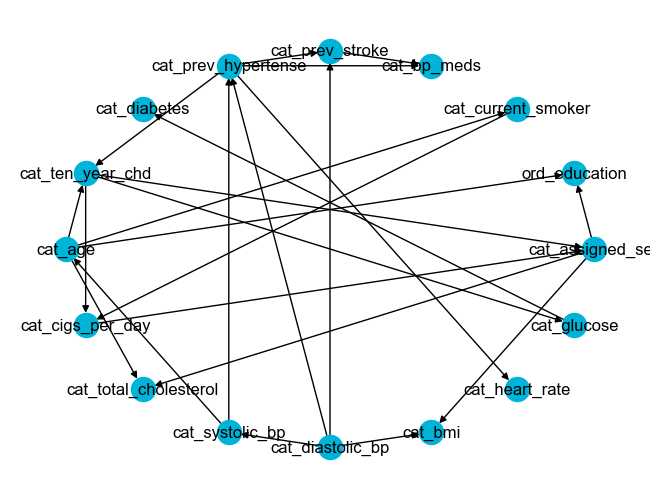

In [22]:
# best bdeu structure
print(best_model_hc_bdeu)
visualize_network(best_model_hc_bdeu)

DAG with 16 nodes and 25 edges


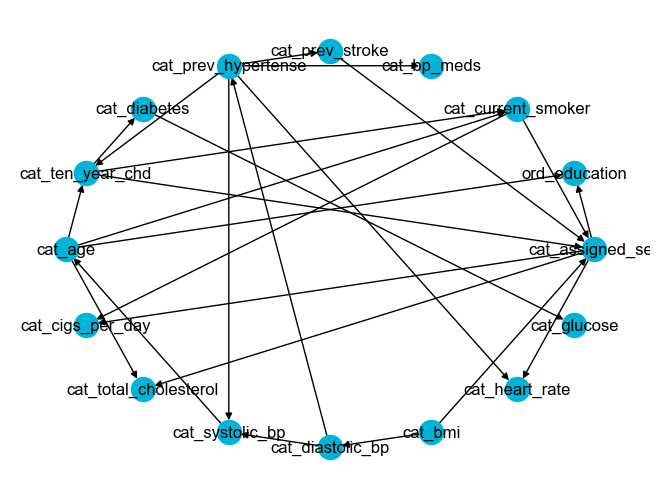

In [23]:
# best k2 structure
print(best_model_hc_k2)
visualize_network(best_model_hc_k2)

DAG with 16 nodes and 18 edges


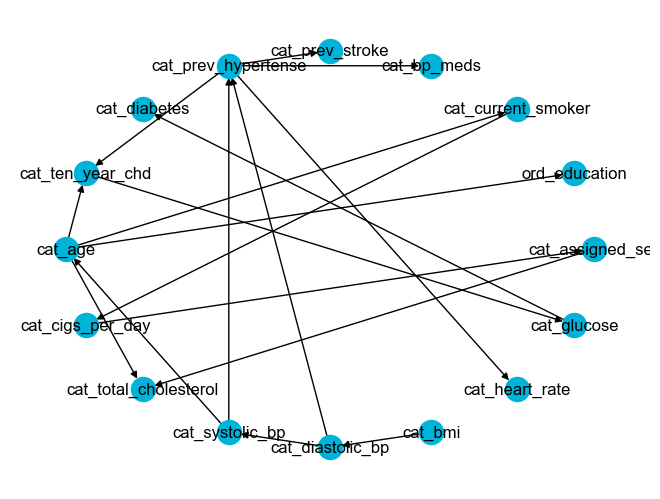

In [24]:
# best bic structure
print(best_model_hc_bic)
visualize_network(best_model_hc_bic)

## Defining the structure of the Bayesian Network
We decided to use three Bayesian Networks, one for each estimator. This will be usefull for the query part ahead, where we will only use the 1 model (the one that has the best score predicting the target variable on the test dataset).

In [25]:
# create Bayesian Network from best DAG within each estimator
bn_bic = BayesianNetwork(best_model_hc_bic.edges())
bn_k2 = BayesianNetwork(best_model_hc_k2.edges())
bn_bdeu = BayesianNetwork(best_model_hc_bdeu.edges())

# 7. Parameter Learning
Learning the parameters of the model using the data and, in this case, a Bayesian Estimator.

In [26]:
# learn cpds/ train model
be_bic = bn_bic.fit(train_data_cat, estimator=BayesianEstimator, prior_type='BDeu')
be_k2 = bn_k2.fit(train_data_cat, estimator=BayesianEstimator, prior_type='K2')
be_bdeu = bn_bdeu.fit(train_data_cat, estimator=BayesianEstimator, prior_type='BDeu')

# print cpds
# for cpd in bn.get_cpds():
    # print(cpd)

# 8. Predicting the target variable (TenYearCHD)
Using the model to predict the target variable, and comparing the results with the original data.

We can see that the model predicts pretty **accurately** when the patient is **not gonna have** CHD, but has some problems telling when the patient **will** have CHD

In [40]:
def predict_target(df, infer, target_col):
    evidence_cols = df.columns.drop(target_col)
    df[f"{target_col}_pred"] = df.apply(lambda row: infer.map_query([target_col], 
                                            evidence=row[evidence_cols].to_dict(),
                                            show_progress=False)[target_col], axis=1)
    return df

# Usage
target_col = 'cat_ten_year_chd'
# test_data_cat = predict_target(test_data_cat, infer, target_col)
# print(f1_score(test_data_cat[target_col], test_data_cat[f"{target_col}_pred"], pos_label='Yes'))
# print(classification_report(test_data_cat[target_col], test_data_cat[f"{target_col}_pred"]))

# Predicting with bic score estimator
y_pred_bic = bn_bic.predict(test_data_cat.drop(columns=["cat_ten_year_chd"]))
print("BIC")
print(f1_score(test_data_cat[target_col], y_pred_bic, pos_label='Yes'))
print(classification_report(test_data_cat[target_col], y_pred_bic))

# Predicting with k2 score estimator
y_pred_k2 = bn_k2.predict(test_data_cat.drop(columns=["cat_ten_year_chd"]))
print("K2")
print(f1_score(test_data_cat[target_col], y_pred_k2, pos_label='Yes'))
print(classification_report(test_data_cat[target_col], y_pred_k2))

# Predicting with bdeu score estimator
y_pred_bdeu = bn_bdeu.predict(test_data_cat.drop(columns=["cat_ten_year_chd"]))
print("BDEU")
print(f1_score(test_data_cat[target_col], y_pred_bdeu, pos_label='Yes'))
print(classification_report(test_data_cat[target_col], y_pred_bdeu))

100%|██████████| 771/771 [00:03<00:00, 213.14it/s]


BIC
0.2820512820512821
              precision    recall  f1-score   support

          No       0.85      0.91      0.88       667
         Yes       0.35      0.24      0.28       140

    accuracy                           0.79       807
   macro avg       0.60      0.57      0.58       807
weighted avg       0.76      0.79      0.77       807



100%|██████████| 771/771 [00:00<00:00, 2117.88it/s]


K2
0.3524904214559387
              precision    recall  f1-score   support

          No       0.86      0.89      0.88       667
         Yes       0.38      0.33      0.35       140

    accuracy                           0.79       807
   macro avg       0.62      0.61      0.61       807
weighted avg       0.78      0.79      0.78       807



100%|██████████| 771/771 [00:00<00:00, 2422.67it/s]


BDEU
0.3726235741444867
              precision    recall  f1-score   support

          No       0.87      0.89      0.88       667
         Yes       0.40      0.35      0.37       140

    accuracy                           0.80       807
   macro avg       0.63      0.62      0.63       807
weighted avg       0.79      0.80      0.79       807



In [28]:
infer = VariableElimination(bn_bdeu) # The model with best results in the prediction

print(infer.query(['cat_ten_year_chd']))
# it makes sense that the model predicts 33% Yes, because of the resampling we did

+-----------------------+-------------------------+
| cat_ten_year_chd      |   phi(cat_ten_year_chd) |
+=======================+=========================+
| cat_ten_year_chd(No)  |                  0.6665 |
+-----------------------+-------------------------+
| cat_ten_year_chd(Yes) |                  0.3335 |
+-----------------------+-------------------------+


## Queries
We can also use the model to answer queries, which can be usefull for example to predict the probability of a patient having CHD given that we are only presented with some variables.

The queries below show that presenting the model with only a small subset of features will produce quite inconclusive evidence for or against the existence of CHD. The highest "certainty" given be the difference between the probability of "Yes" and "No", is achieved when looking at blood pressure and glucose levels together.

In [29]:
# Meaningfull queries

# 1) Does having high cholesterol, high heart rate and high glucose level increase the risk of CHD?
print( infer.query( ["cat_ten_year_chd"], evidence= { "cat_total_cholesterol": "High (>=240)", "cat_heart_rate": "85-99 bpm", "cat_glucose": ">=125 mg/dL" }))

# 2) Does being old, smoking and having a previous stroke increases the risk of CHD?
print( infer.query( ["cat_ten_year_chd"], evidence = { "cat_age": "60-70", "cat_cigs_per_day": "15-24", "cat_prev_stroke": "Yes"}))

# 3) Does having diabetes and being hypertense increases the risk of CHD?
print( infer.query(["cat_ten_year_chd"], evidence = {"cat_diabetes": "Yes", "cat_prev_hypertense": "Yes"} ))

# 4) Does having a college degree reduces the risk of CHD? It does seem like the chance is pretty similar to having just some high school education
print( infer.query( ["cat_ten_year_chd"], evidence = { "ord_education": "college" }))
print( infer.query( ["cat_ten_year_chd"], evidence = { "ord_education": "some high school" }))

# 5) Does being a current smoker increases the risk of CHD?
print( infer.query( ["cat_ten_year_chd"], evidence = {"cat_current_smoker": "Yes" }))

# 6) Does having high blood pressure and high glucose level increases the risk of CHD?
print( infer.query( ["cat_ten_year_chd"], evidence = {"cat_systolic_bp": ">=180 mm HG", "cat_diastolic_bp": ">=120 mm HG", "cat_glucose": ">=125 mg/dL"}))

# 7) Actually, it seems like having high glucose level is a risk factor for CHD for itself!
print( infer.query( ["cat_ten_year_chd"], evidence = {"cat_glucose": ">=125 mg/dL"}))

+-----------------------+-------------------------+
| cat_ten_year_chd      |   phi(cat_ten_year_chd) |
+=======================+=========================+
| cat_ten_year_chd(No)  |                  0.3115 |
+-----------------------+-------------------------+
| cat_ten_year_chd(Yes) |                  0.6885 |
+-----------------------+-------------------------+
+-----------------------+-------------------------+
| cat_ten_year_chd      |   phi(cat_ten_year_chd) |
+=======================+=========================+
| cat_ten_year_chd(No)  |                  0.4227 |
+-----------------------+-------------------------+
| cat_ten_year_chd(Yes) |                  0.5773 |
+-----------------------+-------------------------+
+-----------------------+-------------------------+
| cat_ten_year_chd      |   phi(cat_ten_year_chd) |
+=======================+=========================+
| cat_ten_year_chd(No)  |                  0.3186 |
+-----------------------+-------------------------+
| cat_ten_ye

# 9. Conclusion and next steps
This notebook outlines the pipeline for esimating a Bayesian Network, predicting the presence/absence of CHD. It already shows a high accuracy score which is mainly driven by its strength to correctly predict the absence of CHD. As the model shows to have some difficulties in predicting the presence of CHD, there is still room for improvement. From here, we see two main steps forward:
1. Given that we observed a strong impact of the SMOTE-NC and Undersampling technique, the next experiments would entail tweaking the distriubtion of majority and minority class. 
2. Contacting a medical professional to get more domain knowledge and going over the variable categories to refine them, could be another way forward in improving the model.

# Appendix: Testing for quintile categorization
We decided to test the model with another categorization of the continuous variables, in order to see if we could get a better prediction model.
In sum, the code below is just to check whether our previous categorization was any good or not.

Note: the structure learning takes **A LOT** of time to run!

In [30]:
# random seed in same context
random.seed(random_state)
np.random.seed(random_state)

best_models_results_quintiles = structure_learning(full_data_quintiles, num_start_links=4)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 25/1000000 [00:02<26:07:13, 10.63it/s]


Method: bdeu | Score: -36919.871256340586 | PercInitialLinks: 0% | BestModel: [('cat_assigned_sex', 'quintile_glucose'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_current_smoker', 'cat_diabetes'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_stroke', 'cat_current_smoker'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('cat_ten_year_chd', 'cat_prev_stroke'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'quintile_cigs_per_day'), ('quintile_age', 'ord_education'), ('quintile_cigs_per_day', 'cat_current_smoker'), ('quintile_cigs_per_day', 'cat_assigned_sex'), ('quintile_systolic_bp', 'cat_prev_hypertense'), ('quintile_systolic_bp', 'quintile_age'), ('quintile_diastolic_bp', 'quin

  0%|          | 25/1000000 [00:02<25:59:58, 10.68it/s]


Method: bdeu | Score: -36919.871256340586 | PercInitialLinks: 2.63% | BestModel: [('cat_assigned_sex', 'quintile_glucose'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_current_smoker', 'cat_diabetes'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_stroke', 'cat_current_smoker'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('cat_ten_year_chd', 'cat_prev_stroke'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'quintile_cigs_per_day'), ('quintile_age', 'ord_education'), ('quintile_cigs_per_day', 'cat_current_smoker'), ('quintile_cigs_per_day', 'cat_assigned_sex'), ('quintile_systolic_bp', 'cat_prev_hypertense'), ('quintile_systolic_bp', 'quintile_age'), ('quintile_diastolic_bp', 'q

  0%|          | 32/1000000 [00:03<31:00:16,  8.96it/s]


Method: bdeu | Score: -37000.81456813162 | PercInitialLinks: 9.56% | BestModel: [('cat_assigned_sex', 'quintile_cigs_per_day'), ('cat_assigned_sex', 'quintile_bmi'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'quintile_glucose'), ('cat_assigned_sex', 'cat_bp_meds'), ('ord_education', 'cat_prev_hypertense'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'quintile_cigs_per_day'), ('cat_prev_hypertense', 'quintile_systolic_bp'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_bmi'), ('cat_prev_hypertense', 'quintile_diastolic_bp'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_prev_hypertense', 'quintile_glucose'), ('cat_diabetes', 'cat_current_smoker'), ('cat_ten_year_chd', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_a

  0%|          | 42/1000000 [00:04<28:36:48,  9.71it/s]


Method: bdeu | Score: -36965.605964134564 | PercInitialLinks: 27.26% | BestModel: [('cat_assigned_sex', 'cat_bp_meds'), ('cat_assigned_sex', 'quintile_glucose'), ('cat_assigned_sex', 'quintile_bmi'), ('ord_education', 'cat_assigned_sex'), ('cat_current_smoker', 'quintile_cigs_per_day'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_hypertense', 'quintile_bmi'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'quintile_glucose'), ('cat_ten_year_chd', 'quintile_systolic_bp'), ('cat_ten_year_chd', 'quintile_cigs_per_day'), ('cat_ten_year_chd', 'cat_prev_stroke'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_age', 'ord_education'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'cat_current_smoker'), ('quintile_cigs_per_day', 'cat_assigned_sex'), ('quintile_systolic_bp', 'quintile_diastolic_bp'), ('quintile_systolic_bp', 'cat_prev_hypertense'), ('quintile_systo

  0%|          | 69/1000000 [17:42<4275:50:03, 15.39s/it] 


Method: bdeu | Score: -40416.788285074486 | PercInitialLinks: 78.14% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_assigned_sex', 'quintile_glucose'), ('cat_assigned_sex', 'quintile_bmi'), ('cat_assigned_sex', 'quintile_heart_rate'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'quintile_cigs_per_day'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('ord_education', 'quintile_bmi'), ('ord_education', 'quintile_heart_rate'), ('ord_education', 'quintile_glucose'), ('cat_current_smoker', 'quintile_age'), ('cat_current_smoker', 'quintile_bmi'), ('cat_current_smoker', 'quintile_heart_rate'), ('cat_current_smoker', 'quintile_cigs_per_day'), ('cat_current_smoker', 'quintile_glucose'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'quintile_total_cholesterol'), ('cat_bp_meds', 'quintile_bmi'), ('cat_bp_meds', 'quintile_heart_rate'), ('cat_prev_hypertense', 'quintile_age'), ('cat_prev

  0%|          | 65/1000000 [19:31<5004:00:20, 18.02s/it]  


Method: bdeu | Score: -43780.54500611719 | PercInitialLinks: 100% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_bp_meds'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'quintile_cigs_per_day'), ('cat_assigned_sex', 'quintile_diastolic_bp'), ('cat_assigned_sex', 'quintile_bmi'), ('cat_assigned_sex', 'quintile_heart_rate'), ('cat_assigned_sex', 'quintile_glucose'), ('ord_education', 'quintile_diastolic_bp'), ('ord_education', 'quintile_bmi'), ('ord_education', 'quintile_heart_rate'), ('ord_education', 'quintile_glucose'), ('cat_current_smoker', 'quintile_age'), ('cat_current_smoker', 'quintile_cigs_per_day'), ('cat_current_smoker', 'quintile_diastolic_bp'), ('cat_current_smoker', 'quintile_bmi'), ('cat_current_smoker', 'quintile_heart_rate'), ('cat_current_smoker', 'quintile_glucose'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'quintile_bmi'), (

  0%|          | 30/1000000 [00:02<23:39:58, 11.74it/s]


Method: k2 | Score: -36752.544510658015 | PercInitialLinks: 0% | BestModel: [('cat_assigned_sex', 'quintile_total_cholesterol'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'quintile_glucose'), ('cat_assigned_sex', 'quintile_heart_rate'), ('cat_bp_meds', 'quintile_heart_rate'), ('cat_prev_stroke', 'quintile_diastolic_bp'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_assigned_sex'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'quintile_systolic_bp'), ('cat_prev_hypertense', 'quintile_diastolic_bp'), ('cat_diabetes', 'quintile_glucose'), ('cat_diabetes', 'cat_assigned_sex'), ('cat_ten_year_chd', 'quintile_cigs_per_day'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'ord_education'), ('quintile_age', 'quintile_cigs_per_day'), ('quintile_cigs_p

  0%|          | 27/1000000 [00:02<24:38:03, 11.28it/s]


Method: k2 | Score: -36761.93351012136 | PercInitialLinks: 2.63% | BestModel: [('cat_assigned_sex', 'quintile_bmi'), ('cat_assigned_sex', 'quintile_total_cholesterol'), ('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'quintile_glucose'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'quintile_heart_rate'), ('cat_current_smoker', 'quintile_bmi'), ('cat_current_smoker', 'quintile_age'), ('cat_current_smoker', 'cat_assigned_sex'), ('cat_bp_meds', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'quintile_systolic_bp'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'ord_education'), ('quintile_cigs_per_day', 'cat_current_smoker'), ('quintile_cigs_per_day', '

  0%|          | 32/1000000 [00:02<25:52:11, 10.74it/s]


Method: k2 | Score: -36772.073618207774 | PercInitialLinks: 9.56% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'quintile_cigs_per_day'), ('cat_assigned_sex', 'quintile_total_cholesterol'), ('cat_assigned_sex', 'quintile_bmi'), ('cat_assigned_sex', 'quintile_heart_rate'), ('cat_bp_meds', 'quintile_heart_rate'), ('cat_bp_meds', 'cat_assigned_sex'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'quintile_systolic_bp'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_diastolic_bp'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_diabetes', 'quintile_glucose'), ('cat_diabetes', 'cat_prev_hypertense'), ('cat_ten_year_chd', 'cat_assigned_sex'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'quintile_cigs_per_day'), ('quintile_age', 'ord_education'), ('quintile_cigs_per_day', 'cat_current_smoker'), ('quintile_s

  0%|          | 46/1000000 [00:04<25:23:43, 10.94it/s]


Method: k2 | Score: -36788.283200303464 | PercInitialLinks: 27.26% | BestModel: [('cat_assigned_sex', 'quintile_cigs_per_day'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'quintile_total_cholesterol'), ('cat_assigned_sex', 'quintile_glucose'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('ord_education', 'quintile_age'), ('ord_education', 'cat_assigned_sex'), ('cat_current_smoker', 'quintile_cigs_per_day'), ('cat_bp_meds', 'quintile_age'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'quintile_systolic_bp'), ('cat_bp_meds', 'cat_assigned_sex'), ('cat_prev_stroke', 'cat_assigned_sex'), ('cat_prev_hypertense', 'quintile_diastolic_bp'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'quintile_systolic_bp'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'cat_current_smok

  0%|          | 64/1000000 [09:57<2593:40:37,  9.34s/it] 


Method: k2 | Score: -37028.04511571616 | PercInitialLinks: 78.14% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'quintile_total_cholesterol'), ('cat_assigned_sex', 'quintile_bmi'), ('cat_assigned_sex', 'quintile_heart_rate'), ('cat_assigned_sex', 'quintile_glucose'), ('ord_education', 'quintile_total_cholesterol'), ('ord_education', 'quintile_glucose'), ('ord_education', 'quintile_heart_rate'), ('cat_current_smoker', 'cat_prev_hypertense'), ('cat_current_smoker', 'quintile_age'), ('cat_current_smoker', 'quintile_bmi'), ('cat_current_smoker', 'cat_assigned_sex'), ('cat_bp_meds', 'cat_ten_year_chd'), ('cat_bp_meds', 'quintile_bmi'), ('cat_bp_meds', 'quintile_heart_rate'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_ten_year_chd'), ('cat_prev_stroke', 'quintile_heart_rate'), ('cat_prev_stroke', 'quintile_glucose'), ('cat_prev_stroke', 'cat_bp_meds'), ('cat_prev_hypertense', 'cat_diabetes'), ('ca

  0%|          | 67/1000000 [28:05<6988:53:48, 25.16s/it]   


Method: k2 | Score: -37036.75799056613 | PercInitialLinks: 100% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'quintile_cigs_per_day'), ('cat_assigned_sex', 'quintile_total_cholesterol'), ('cat_assigned_sex', 'quintile_bmi'), ('cat_assigned_sex', 'quintile_heart_rate'), ('cat_assigned_sex', 'quintile_glucose'), ('ord_education', 'quintile_total_cholesterol'), ('ord_education', 'quintile_heart_rate'), ('ord_education', 'quintile_glucose'), ('cat_current_smoker', 'quintile_age'), ('cat_current_smoker', 'quintile_cigs_per_day'), ('cat_current_smoker', 'quintile_bmi'), ('cat_current_smoker', 'quintile_glucose'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_bp_meds', 'quintile_bmi'), ('cat_bp_meds', 'quintile_heart_rate'), ('cat_bp_meds', 'quintile_glucose'), ('cat_bp_meds', 'cat_assigned_sex'), ('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_stroke', 'cat_ten_year_chd'), ('cat_prev_stroke', 'quintile_heart_rate

  0%|          | 17/1000000 [00:01<29:37:08,  9.38it/s]


Method: bic | Score: -37035.16969539315 | PercInitialLinks: 0% | BestModel: [('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'quintile_cigs_per_day'), ('quintile_age', 'ord_education'), ('quintile_cigs_per_day', 'cat_current_smoker'), ('quintile_cigs_per_day', 'cat_assigned_sex'), ('quintile_systolic_bp', 'cat_prev_hypertense'), ('quintile_systolic_bp', 'quintile_age'), ('quintile_diastolic_bp', 'quintile_systolic_bp'), ('quintile_bmi', 'quintile_diastolic_bp'), ('quintile_bmi', 'cat_assigned_sex')]


  0%|          | 17/1000000 [00:01<30:43:14,  9.04it/s]


Method: bic | Score: -37067.689501837966 | PercInitialLinks: 2.63% | BestModel: [('cat_current_smoker', 'quintile_systolic_bp'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_diabetes', 'quintile_glucose'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_age', 'ord_education'), ('quintile_cigs_per_day', 'cat_current_smoker'), ('quintile_cigs_per_day', 'cat_assigned_sex'), ('quintile_systolic_bp', 'quintile_diastolic_bp'), ('quintile_systolic_bp', 'quintile_age'), ('quintile_systolic_bp', 'cat_prev_hypertense'), ('quintile_diastolic_bp', 'quintile_bmi'), ('quintile_bmi', 'cat_assigned_sex')]


  0%|          | 22/1000000 [00:02<27:55:54,  9.94it/s]


Method: bic | Score: -37035.16969539315 | PercInitialLinks: 9.56% | BestModel: [('cat_prev_stroke', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'quintile_systolic_bp'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'quintile_cigs_per_day'), ('quintile_age', 'ord_education'), ('quintile_age', 'quintile_total_cholesterol'), ('quintile_cigs_per_day', 'cat_current_smoker'), ('quintile_cigs_per_day', 'cat_assigned_sex'), ('quintile_systolic_bp', 'quintile_diastolic_bp'), ('quintile_systolic_bp', 'quintile_age'), ('quintile_diastolic_bp', 'quintile_bmi'), ('quintile_bmi', 'cat_assigned_sex')]


  0%|          | 41/1000000 [00:03<25:22:53, 10.94it/s]


Method: bic | Score: -37218.23633697464 | PercInitialLinks: 27.26% | BestModel: [('cat_assigned_sex', 'quintile_bmi'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('ord_education', 'quintile_age'), ('ord_education', 'cat_assigned_sex'), ('cat_current_smoker', 'quintile_cigs_per_day'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'quintile_total_cholesterol'), ('cat_prev_hypertense', 'quintile_bmi'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'quintile_systolic_bp'), ('cat_prev_hypertense', 'cat_prev_stroke'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'quintile_diastolic_bp'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_age', 'cat_ten_year_chd'), ('quintile_age', 'cat_current_smoker'), ('quintile_cigs_per_day', 'cat_assigned_sex'), ('quintile_diastolic_bp', 'quintile_systolic_bp'), ('quintile_diastolic_bp', 'cat_prev_hypertense'), ('quintile_diastolic_bp', 'cat_bp_meds')]


  0%|          | 82/1000000 [00:30<103:18:42,  2.69it/s]


Method: bic | Score: -37129.23814654524 | PercInitialLinks: 78.14% | BestModel: [('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'quintile_cigs_per_day'), ('cat_assigned_sex', 'ord_education'), ('cat_current_smoker', 'cat_prev_hypertense'), ('cat_current_smoker', 'quintile_age'), ('cat_current_smoker', 'quintile_cigs_per_day'), ('cat_current_smoker', 'cat_assigned_sex'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'quintile_age'), ('cat_prev_hypertense', 'quintile_systolic_bp'), ('cat_prev_hypertense', 'quintile_diastolic_bp'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'quintile_bmi'), ('cat_prev_hypertense', 'quintile_total_cholesterol'), ('cat_prev_hypertense', 'cat_bp_meds'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'quintile_age'), ('cat_ten_year_chd', 'cat_diabetes'), ('quintile_diastolic_bp', 'quintile_systolic_bp'), ('quintile_bmi', 'cat_assigned_sex')]


  0%|          | 103/1000000 [14:55<2414:48:03,  8.69s/it] 


Method: bic | Score: -37129.62708483122 | PercInitialLinks: 100% | BestModel: [('cat_assigned_sex', 'ord_education'), ('cat_assigned_sex', 'cat_current_smoker'), ('cat_assigned_sex', 'cat_ten_year_chd'), ('cat_assigned_sex', 'quintile_cigs_per_day'), ('cat_current_smoker', 'quintile_age'), ('cat_current_smoker', 'quintile_cigs_per_day'), ('cat_bp_meds', 'cat_prev_stroke'), ('cat_bp_meds', 'cat_prev_hypertense'), ('cat_prev_hypertense', 'cat_diabetes'), ('cat_prev_hypertense', 'cat_ten_year_chd'), ('cat_prev_hypertense', 'quintile_age'), ('cat_prev_hypertense', 'quintile_total_cholesterol'), ('cat_prev_hypertense', 'quintile_systolic_bp'), ('cat_prev_hypertense', 'quintile_diastolic_bp'), ('cat_prev_hypertense', 'quintile_bmi'), ('cat_prev_hypertense', 'quintile_heart_rate'), ('cat_prev_hypertense', 'cat_current_smoker'), ('cat_diabetes', 'quintile_glucose'), ('cat_ten_year_chd', 'quintile_age'), ('quintile_diastolic_bp', 'quintile_systolic_bp'), ('quintile_bmi', 'cat_assigned_sex')]


In [31]:
# get best models
best_model_hc_bdeu_quintiles = best_models_results_quintiles["bdeu"]["model"]
best_model_hc_k2_quintiles = best_models_results_quintiles["k2"]["model"]
best_model_hc_bic_quintiles = best_models_results_quintiles["bic"]["model"]

DAG with 16 nodes and 25 edges


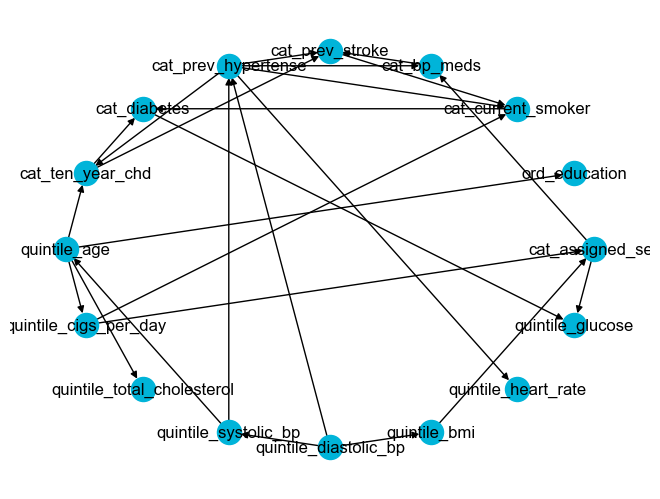

In [32]:
# best bdeu structure
print(best_model_hc_bdeu_quintiles)
visualize_network(best_model_hc_bdeu_quintiles)

DAG with 16 nodes and 27 edges


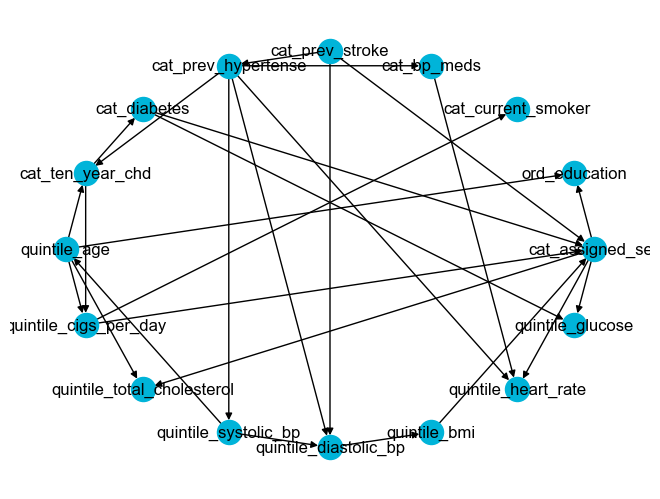

In [33]:
# best k2 structure
print(best_model_hc_k2_quintiles)
visualize_network(best_model_hc_k2_quintiles)

DAG with 16 nodes and 17 edges


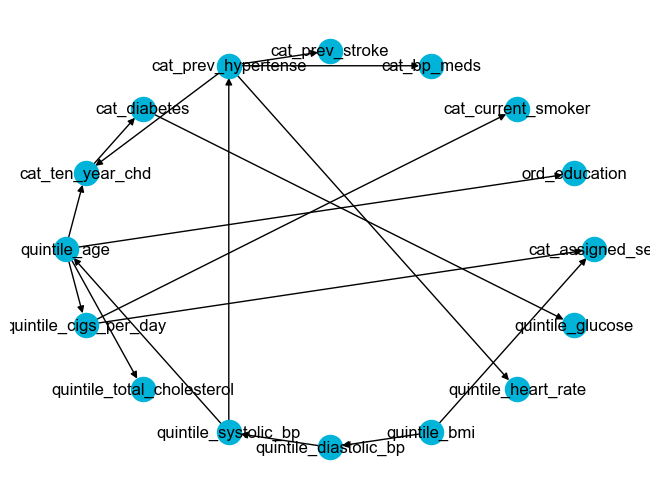

In [34]:
# best bic structure
print(best_model_hc_bic_quintiles)
visualize_network(best_model_hc_bic_quintiles)

In [35]:
# create Bayesian Network from best DAG within each estimator
bn_bic_quintiles = BayesianNetwork(best_model_hc_bic_quintiles.edges())
bn_k2_quintiles = BayesianNetwork(best_model_hc_k2_quintiles.edges())
bn_bdeu_quintiles = BayesianNetwork(best_model_hc_bdeu_quintiles.edges())

In [36]:
# learn cpds/ train model
be_bic_quintiles = bn_bic_quintiles.fit(train_data_quintiles, estimator=BayesianEstimator, prior_type='BDeu')
be_k2_quintiles = bn_k2_quintiles.fit(train_data_quintiles, estimator=BayesianEstimator, prior_type='K2')
be_bdeu_quintiles = bn_bdeu_quintiles.fit(train_data_quintiles, estimator=BayesianEstimator, prior_type='BDeu')

In [37]:
test_data_quintiles

,cat_assigned_sex,ord_education,cat_current_smoker,cat_bp_meds,cat_prev_stroke,cat_prev_hypertense,cat_diabetes,cat_ten_year_chd,quintile_age,quintile_cigs_per_day,quintile_total_cholesterol,quintile_systolic_bp,quintile_diastolic_bp,quintile_bmi,quintile_heart_rate,quintile_glucose
2262,female,high school/GED,Yes,No,No,No,No,No,Quintile 1,Quintile 1,Quintile 5,Quintile 3,Quintile 4,Quintile 5,Quintile 5,Quintile 1
1802,female,some college/vocational school,No,No,No,No,No,No,Quintile 4,Quintile 1,Quintile 3,Quintile 4,Quintile 4,Quintile 4,Quintile 2,Quintile 5
1542,female,some high school,Yes,No,No,No,No,No,Quintile 3,Quintile 1,Quintile 3,Quintile 1,Quintile 1,Quintile 2,Quintile 5,Quintile 1
1354,female,high school/GED,No,No,No,No,No,No,Quintile 3,Quintile 1,Quintile 3,Quintile 3,Quintile 2,Quintile 4,Quintile 2,Quintile 3
3782,female,college,No,No,No,Yes,No,No,Quintile 4,Quintile 1,Quintile 5,Quintile 5,Quintile 4,Quintile 3,Quintile 5,Quintile 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,female,some high school,Yes,No,No,No,No,No,Quintile 1,Quintile 2,Quintile 1,Quintile 4,Quintile 3,Quintile 2,Quintile 1,Quintile 3
3660,female,high school/GED,Yes,No,No,No,Yes,No,Quintile 2,Quintile 2,Quintile 3,Quintile 1,Quintile 1,Quintile 1,Quintile 3,Quintile 5
349,male,some high school,Yes,No,No,No,No,No,Quintile 2,Quintile 3,Quintile 1,Quintile 3,Quintile 3,Quintile 5,Quintile 3,Quintile 2
1013,male,high school/GED,No,No,No,No,No,No,Quintile 3,Quintile 1,Quintile 5,Quintile 4,Quintile 3,Quintile 4,Quintile 4,Quintile 4


## Predicting the target variable with the new categorization
Comparing the results with the previous model, we can see that the new model has worse prediction results than the last one. Nevertheless, it was worth the try for comparison purposes.

In [38]:
# Usage
target_col = 'cat_ten_year_chd'
# test_data_cat = predict_target(test_data_cat, infer, target_col)
# print(f1_score(test_data_cat[target_col], test_data_cat[f"{target_col}_pred"], pos_label='Yes'))
# print(classification_report(test_data_cat[target_col], test_data_cat[f"{target_col}_pred"]))

# Predicting with bic score estimator
y_pred_bic = bn_bic_quintiles.predict(test_data_quintiles.drop(columns=["cat_ten_year_chd"]))
print("BIC")
print(f1_score(test_data_quintiles[target_col], y_pred_bic, pos_label='Yes'))
print(classification_report(test_data_quintiles[target_col], y_pred_bic))

# Predicting with k2 score estimator
y_pred_k2 = bn_k2_quintiles.predict(test_data_quintiles.drop(columns=["cat_ten_year_chd"]))
print("K2")
print(f1_score(test_data_quintiles[target_col], y_pred_k2, pos_label='Yes'))
print(classification_report(test_data_quintiles[target_col], y_pred_k2))

# Predicting with bdeu score estimator
y_pred_bdeu = bn_bdeu_quintiles.predict(test_data_quintiles.drop(columns=["cat_ten_year_chd"]))
print("BDEU")
print(f1_score(test_data_quintiles[target_col], y_pred_bdeu, pos_label='Yes'))
print(classification_report(test_data_quintiles[target_col], y_pred_bdeu))

100%|██████████| 806/806 [00:03<00:00, 206.47it/s]


BIC
0.34013605442176864
              precision    recall  f1-score   support

          No       0.86      0.84      0.85       667
         Yes       0.32      0.36      0.34       140

    accuracy                           0.76       807
   macro avg       0.59      0.60      0.60       807
weighted avg       0.77      0.76      0.76       807



100%|██████████| 806/806 [00:00<00:00, 2310.26it/s]


K2
0.3471698113207547
              precision    recall  f1-score   support

          No       0.86      0.88      0.87       667
         Yes       0.37      0.33      0.35       140

    accuracy                           0.79       807
   macro avg       0.62      0.61      0.61       807
weighted avg       0.78      0.79      0.78       807



100%|██████████| 806/806 [00:00<00:00, 2538.89it/s]


BDEU
0.32191780821917804
              precision    recall  f1-score   support

          No       0.86      0.84      0.85       667
         Yes       0.31      0.34      0.32       140

    accuracy                           0.75       807
   macro avg       0.58      0.59      0.59       807
weighted avg       0.76      0.75      0.76       807



In [39]:
# Model testing

# --- This is not working properly, so I just bypassed it --
# from pgmpy.metrics import correlation_score
# best_estimator = ""
# val = -1
# for score_method_name in sl_results.keys():
#     cor_score = correlation_score( sl_results[score_method_name] ,train_data)
#     if cor_score >  val:
#         best_estimator = score_method_name
#     print(f'Score {score_method_name} method: {cor_score}')

